In [15]:
from dash import dcc, html, Output, Input
from jupyter_dash import JupyterDash
import plotly.express as px
import base64, pandas as pd
from datetime import date
import plotly.io as pio
import numpy as np
import os, sys

pio.renderers.default = 'notebook_connected'
# config the directory path
sys.path.insert(0,os.path.realpath(os.path.pardir))
from utils.tools import image
from utils.config import cfg

In [16]:
# read the data that matches the specified DateTime to the location of the image
df = pd.read_pickle(cfg.ONM_PD.RAINY_TEST).drop(['RADAR_RGB_PNG_PATH', 'RADAR_dBZ_PNG_PATH', 'RADAR_MASK_PATH'], axis=1)
df.reset_index(inplace=True)
df['DateTime'] = df['DateTime'].apply(lambda x: x.strftime("%Y-%m-%d, %H:%M:%S"))
df = df.iloc[5:]

folderPathTarget = '../data/bkk_radar_images_dBZ/'  # specify the path of images
folderPathModel_1 = '../data/bkk_radar_images_prediction/conv2d_10000/' 
folderPathModel_2 = '../data/bkk_radar_images_prediction/convLSTM_BMSE_BMAE/'  
folderPathModel_3 = '../data/bkk_radar_images_prediction/trajGRU_BMSE_BMAE/'  

df['FolderPathTarget'] = folderPathTarget
df['FolderPathModel_1'] = folderPathModel_1
df['FolderPathModel_2'] = folderPathModel_2
df['FolderPathModel_3'] = folderPathModel_3

df.head(3)

DateTime    FileName               FolderPathTarget  \
5  2021-05-01, 07:00:00  1619852548  ../data/bkk_radar_images_dBZ/   
6  2021-05-01, 07:05:00  1619852844  ../data/bkk_radar_images_dBZ/   
7  2021-05-01, 07:10:00  1619853144  ../data/bkk_radar_images_dBZ/   

                                   FolderPathModel_1  \
5  ../data/bkk_radar_images_prediction/conv2d_10000/   
6  ../data/bkk_radar_images_prediction/conv2d_10000/   
7  ../data/bkk_radar_images_prediction/conv2d_10000/   

                                   FolderPathModel_2  \
5  ../data/bkk_radar_images_prediction/convLSTM_B...   
6  ../data/bkk_radar_images_prediction/convLSTM_B...   
7  ../data/bkk_radar_images_prediction/convLSTM_B...   

                                   FolderPathModel_3  
5  ../data/bkk_radar_images_prediction/trajGRU_BM...  
6  ../data/bkk_radar_images_prediction/trajGRU_BM...  
7  ../data/bkk_radar_images_prediction/trajGRU_BM...

## Dashboard

In [17]:
# extract the DateTime column
DateTime = df['DateTime']
DateTime.head(3)

5    2021-05-01, 07:00:00
6    2021-05-01, 07:05:00
7    2021-05-01, 07:10:00
Name: DateTime, dtype: object

In [18]:
# extract the Date
Date = DateTime.str.split(', ').str[0].unique()

min_date_allowed = [int(i) for i in Date[0].split('-')]
max_date_allowed = [int(j) for j in Date[-1].split('-')]

In [19]:
# extract the timestamp and create a dictionary
Time = {}
for d in Date:
    Time[d] = DateTime[DateTime.str.contains(d)].str.split(' ').str[1]

In [21]:
# Dash section
app = JupyterDash(__name__)

app.layout = html.Div([
    html.Div([
        html.Div([
            html.H1('Data Science Project 2 (2021/2):  Nowcasting', className='bg-primary full-size text-white', style={'padding': '5px'}),

            html.Div([
            
                    html.P('Date: ', className='text-base text-white'),
                    dcc.DatePickerSingle(
                        id='date-picker',
                        min_date_allowed=date(min_date_allowed[0], min_date_allowed[1], min_date_allowed[2]),
                        max_date_allowed=date(max_date_allowed[0], max_date_allowed[1], max_date_allowed[2]),
                        initial_visible_month=date(min_date_allowed[0], min_date_allowed[1], min_date_allowed[2]),
                        date=date(min_date_allowed[0], min_date_allowed[1], min_date_allowed[2]),
                        className='DateInput_1'
                    ),  
                    html.P('Time: ', className="text-base text-white"),
                    dcc.Dropdown(id='time-dropdown', className='dropdown-list')

            ], style={'gap': '20px', 'align-items': 'center'},
                className='bg-primary flex-center'),

            ], 
        style={'display': 'flex', 'flexDirection': 'column'},
        className='col-span-4'),

        html.Div([

            html.Div([
                html.Img(id='target', className='img-width-height'),
                html.P('TARGET', className='text-center text-base full-size bg-primary text-white')
                ], className='flex-center',
                    style={'flexDirection': 'column'}),
            html.Div([
                html.Img(id='model_1', className='img-width-height'),
                html.P('conv2d_10000', className='text-center text-base full-size bg-primary text-white')
                ], className='flex-center',
                    style={'flexDirection': 'column'}),
            html.Div([
                html.Img(id='model_2', className='img-width-height'),
                html.P('convLSTM_BMSE_BMAE', className='text-center text-base full-size bg-primary text-white')
                ], className='flex-center',
                    style={'flexDirection': 'column'}),
            html.Div([
                html.Img(id='model_3', className='img-width-height'),
                html.P('trajGRU_BMSE_BMAE', className='text-center text-base full-size bg-primary text-white')
                ], className='flex-center',
                    style={'flexDirection': 'column'}),

        ], className="col-span-4 flex-around"),

    ], className='container font-mono'),
])

@app.callback(
    Output('time-dropdown', 'options'),
    Output('time-dropdown', 'value'),
    Input('date-picker', 'date')
)
def updateTimeDropdown(date):
    date = str(date)
    return ([{'label': i, 'value': i} for i in Time[date]], Time[date].iloc[0])

@app.callback(
    Output('target', 'src'),
    Output('model_1', 'src'),
    Output('model_2', 'src'),
    Output('model_3', 'src'),
    Input('date-picker', 'date'),
    Input('time-dropdown', 'value'),
)
def updateImg(date, time):
    target_df = df.loc[df['DateTime'] == f'{date}, {time}', ['FolderPathTarget', 'FileName']]
    model_1_df = df.loc[df['DateTime'] == f'{date}, {time}', ['FolderPathModel_1', 'FileName']]
    model_2_df = df.loc[df['DateTime'] == f'{date}, {time}', ['FolderPathModel_2', 'FileName']]
    model_3_df = df.loc[df['DateTime'] == f'{date}, {time}', ['FolderPathModel_3', 'FileName']]

    target_path = target_df.iloc[0,0] + target_df.iloc[0,1] + '.png'
    model_1_path = model_1_df.iloc[0,0] + model_1_df.iloc[0,1] + '.png'
    model_2_path = model_2_df.iloc[0,0] + model_2_df.iloc[0,1] + '.png'
    model_3_path = model_3_df.iloc[0,0] + model_3_df.iloc[0,1] + '.png'
    
    encoded_image = base64.b64encode(open(target_path, 'rb').read())
    targets = 'data:image/png;base64,{}'.format(encoded_image.decode())
    encoded_image = base64.b64encode(open(model_1_path, 'rb').read())
    model_1 = 'data:image/png;base64,{}'.format(encoded_image.decode())
    encoded_image = base64.b64encode(open(model_2_path, 'rb').read())
    model_2 = 'data:image/png;base64,{}'.format(encoded_image.decode())
    encoded_image = base64.b64encode(open(model_3_path, 'rb').read())
    model_3 = 'data:image/png;base64,{}'.format(encoded_image.decode())
    return (targets, model_1, model_2, model_3)

if __name__ == '__main__':
    app.run_server(mode='inline')

## Animation frame

In [24]:
# Dataloader class used to load images
class Dataloader():
    def __init__(self, pd_path):
        self.data = None
        self.df = pd_path.copy()
    
    def _load(self, img_num, frame_size, resize=False, greyscale=True):
        self.df['img_path'] = self.df['FolderPath'] + self.df['FileName'] + ".png"
        self.data = image.quick_read_frames(path_list=self.df['img_path'].tolist()[:img_num], resize=resize, grayscale=greyscale, frame_size_in=frame_size)  

In [27]:
desired_date = '2021-05-01'  # yyyy-mm-dd
number_of_images = 50

target_cols = ['FolderPathModel_1', 'FileName']
mask = df.loc[df['DateTime'].str.contains(desired_date), target_cols]
mask.rename(columns={target_cols[0]: 'FolderPath'}, inplace=True)

dataloader_model_1 = Dataloader(mask)
dataloader_model_1._load(number_of_images, resize=True, frame_size=(480, 480))

In [28]:
target_cols = ['FolderPathModel_2', 'FileName']
mask = df.loc[df['DateTime'].str.contains(desired_date), target_cols]
mask.rename(columns={target_cols[0]: 'FolderPath'}, inplace=True)

dataloader_model_2 = Dataloader(mask)
dataloader_model_2._load(number_of_images, resize=True, frame_size=(480, 480))

In [29]:
target_cols = ['FolderPathModel_3', 'FileName']
mask = df.loc[df['DateTime'].str.contains(desired_date), target_cols]
mask.rename(columns={target_cols[0]: 'FolderPath'}, inplace=True)

dataloader_model_3= Dataloader(mask)
dataloader_model_3._load(number_of_images, resize=True, frame_size=(480, 480))

In [30]:
# rehape the loaded data
data = dataloader_model_1.data
data = data.transpose(0, 2, 3, 1)[:,:,:,0]

data2 = dataloader_model_2.data
data2 = data2.transpose(0, 2, 3, 1)[:,:,:,0]

data3 = dataloader_model_3.data
data3 = data3.transpose(0, 2, 3, 1)[:,:,:,0]

print(data.shape, data2.shape, data3.shape)

(50, 480, 480) (50, 480, 480) (50, 480, 480)



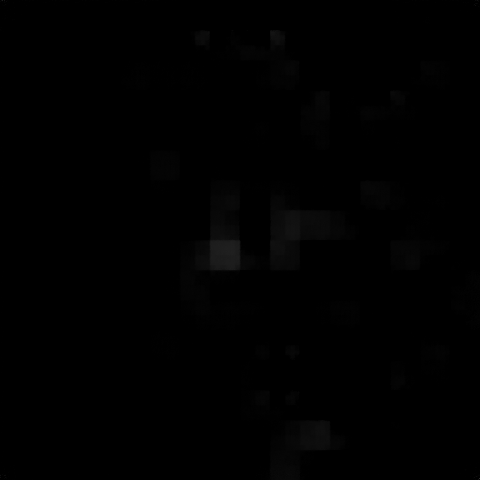
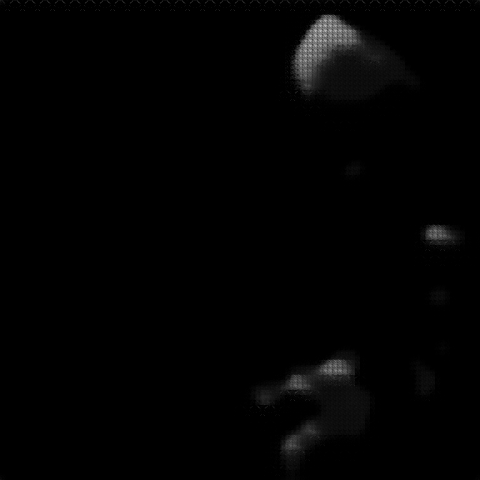
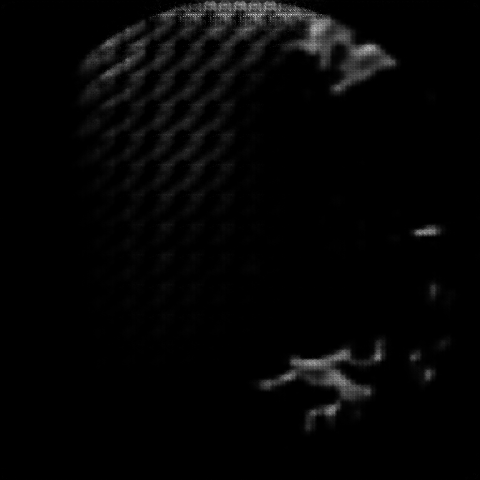
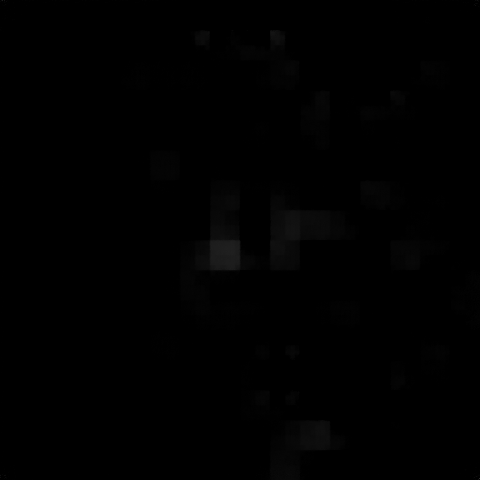
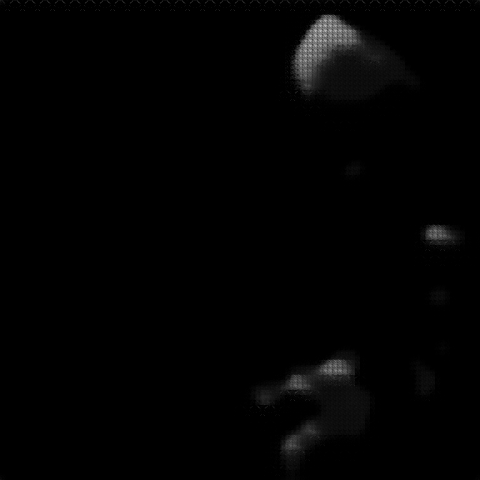
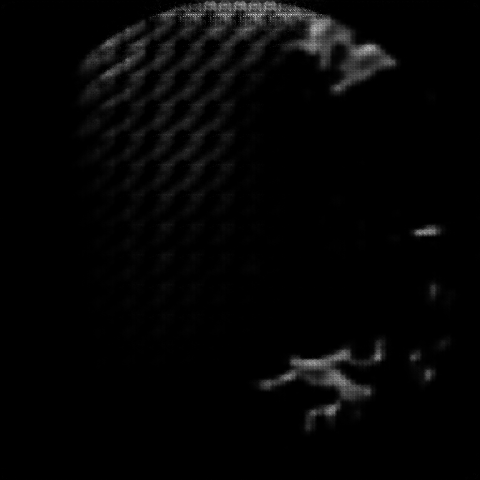
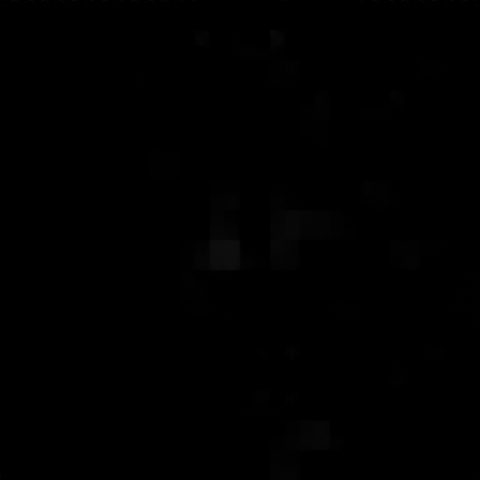
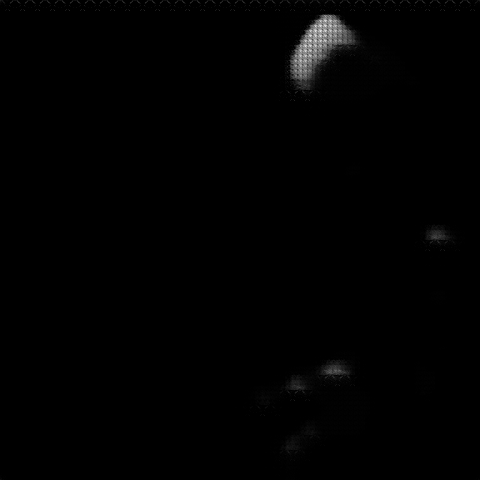
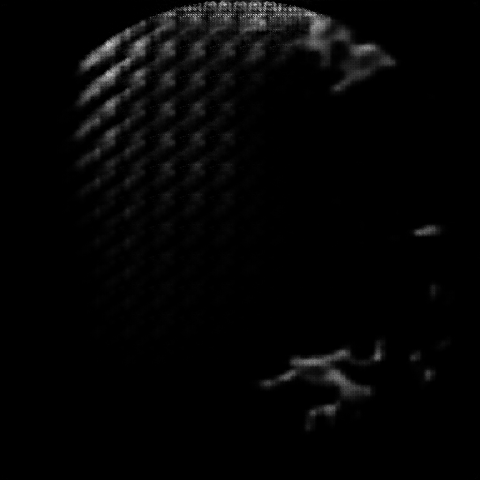
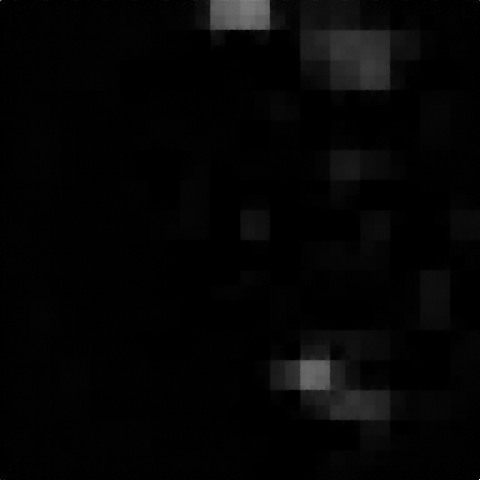
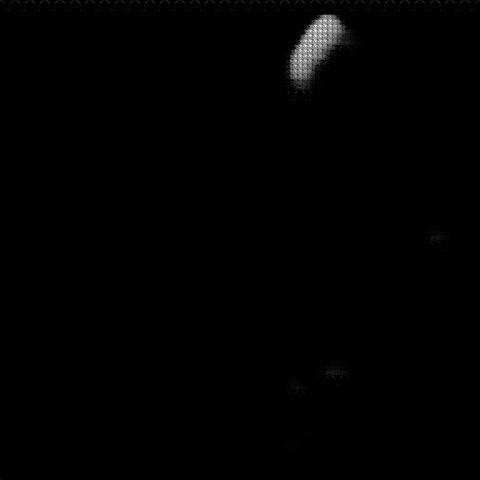
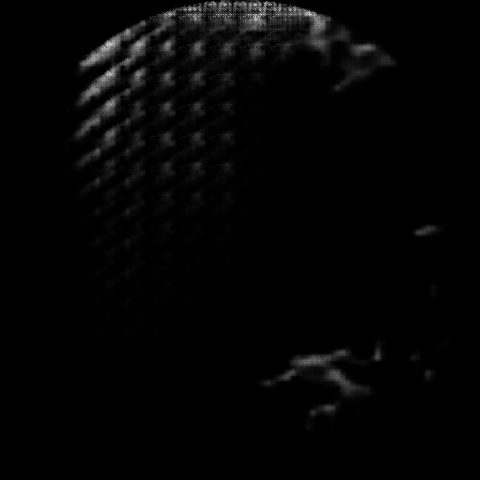
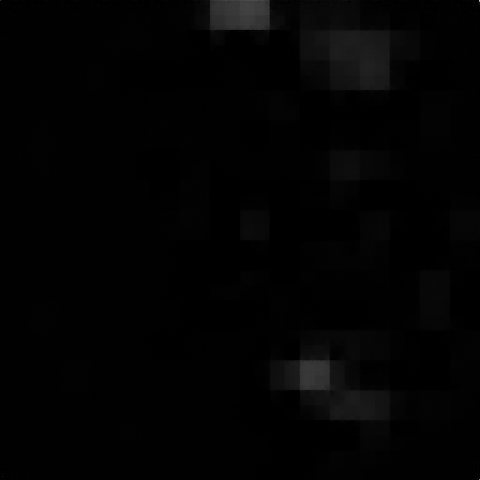
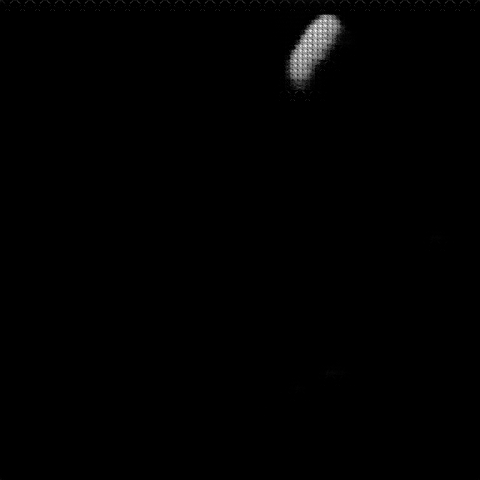
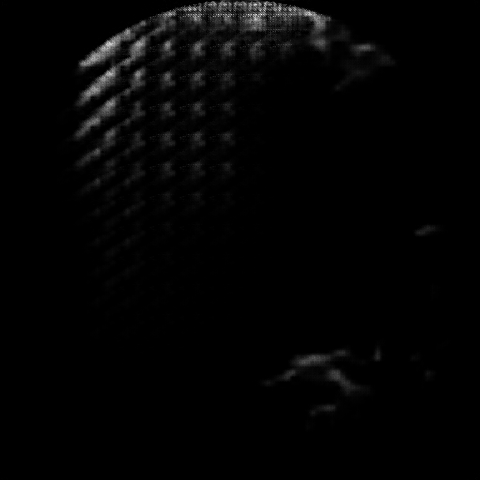
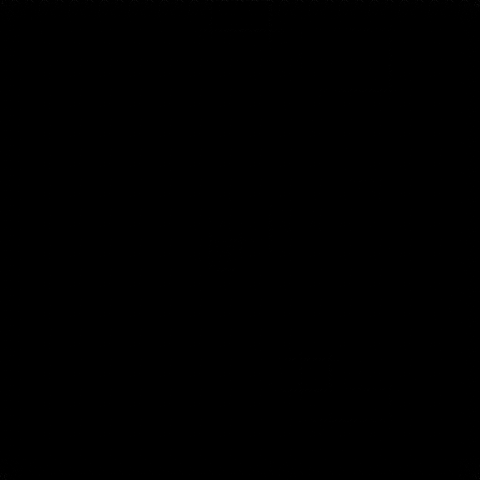
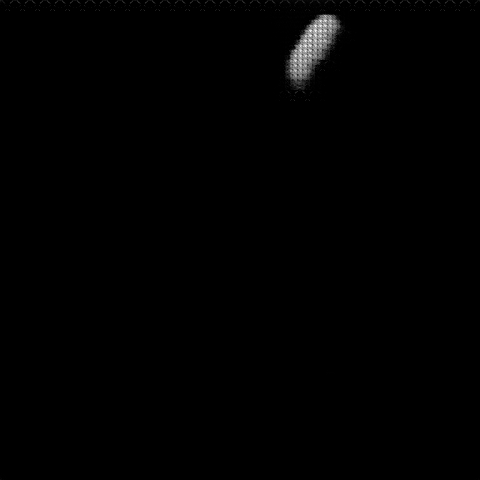
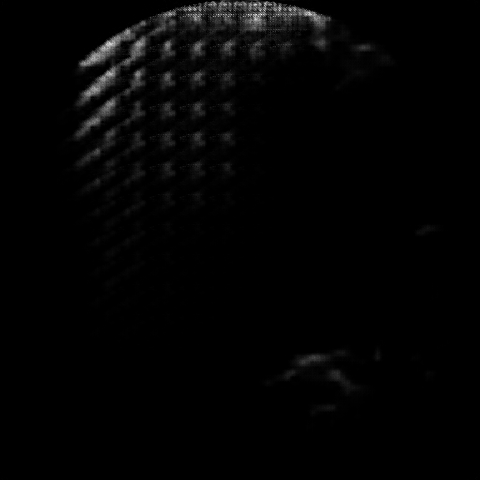
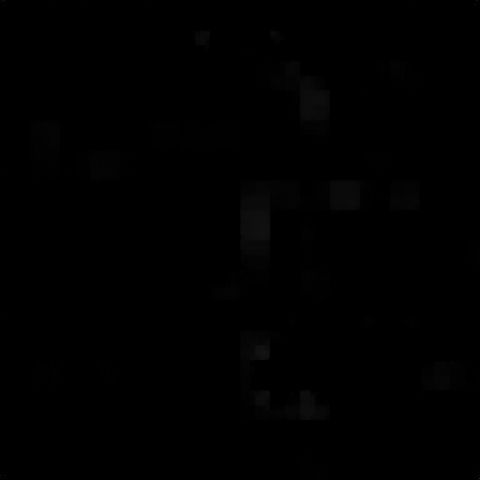
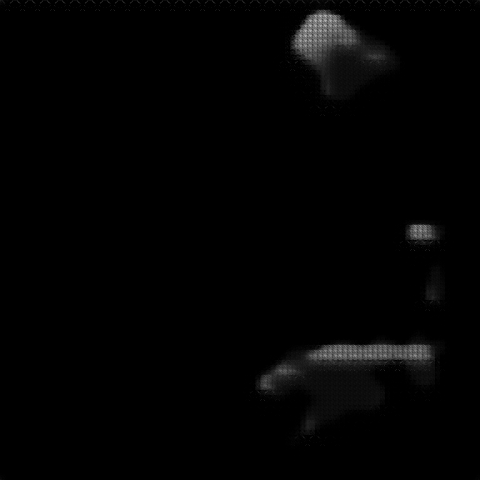
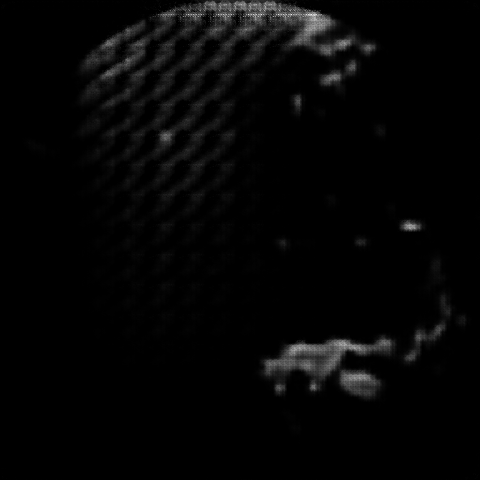
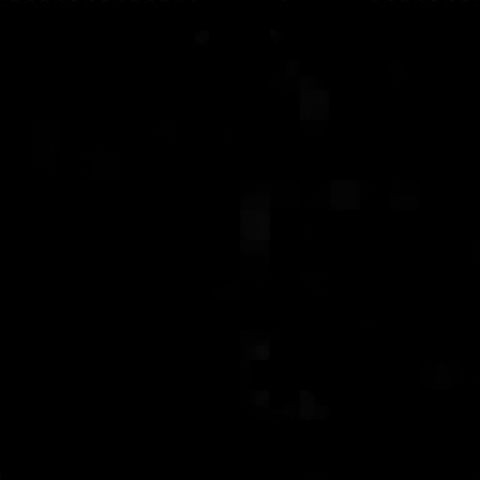
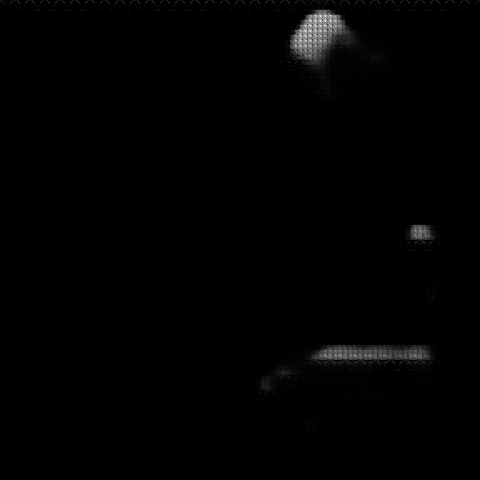
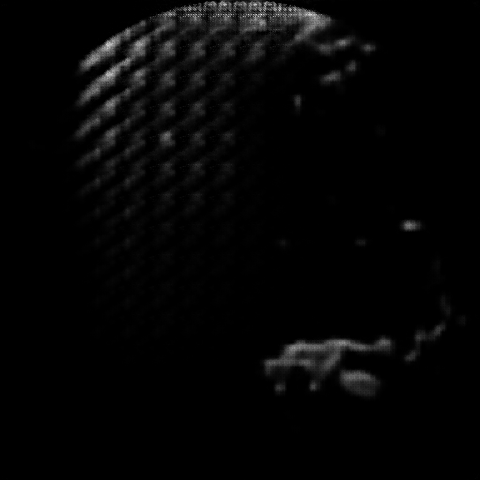
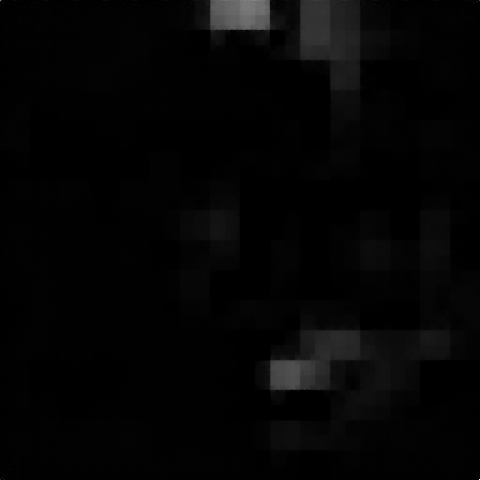
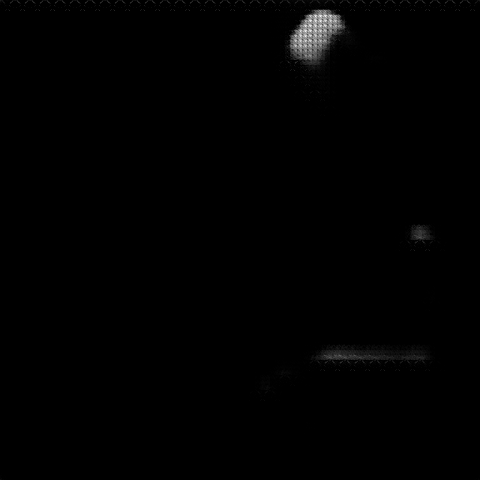
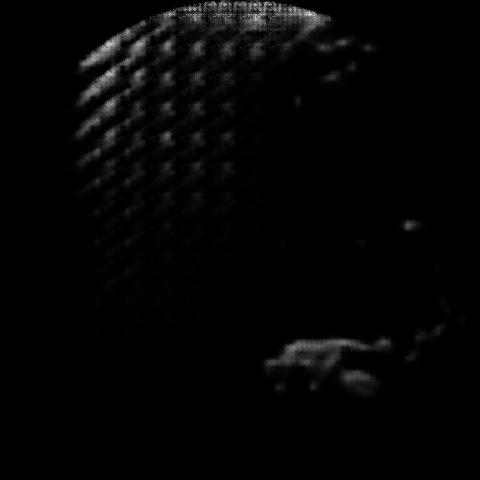
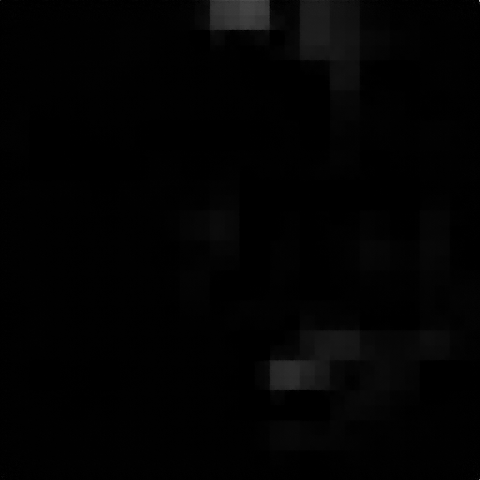
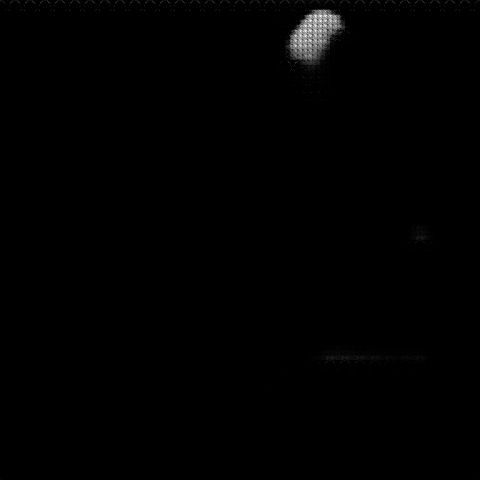
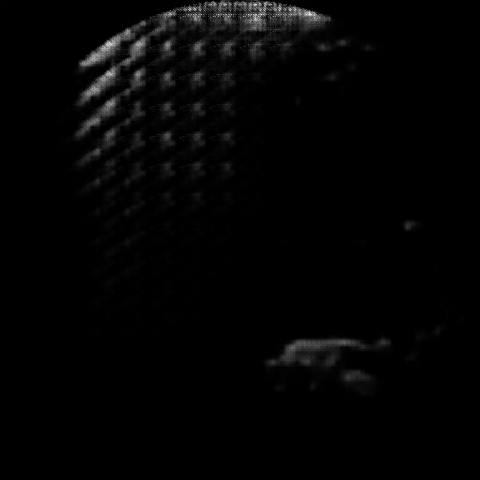
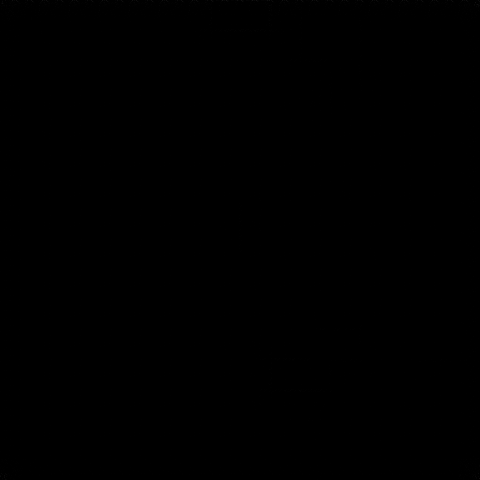
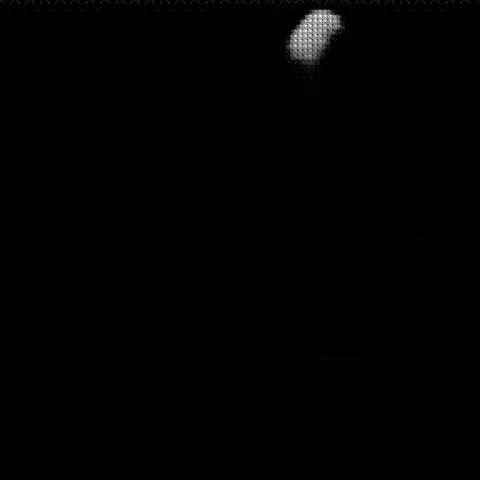
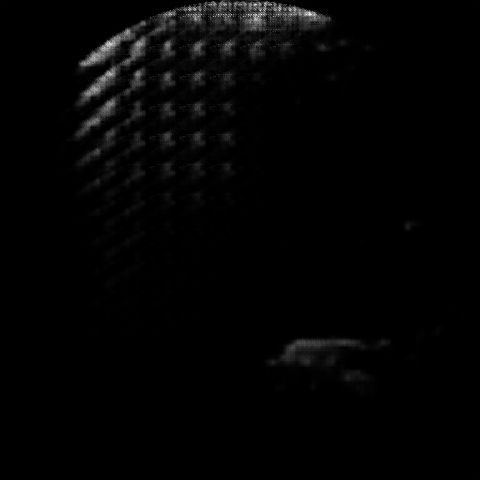
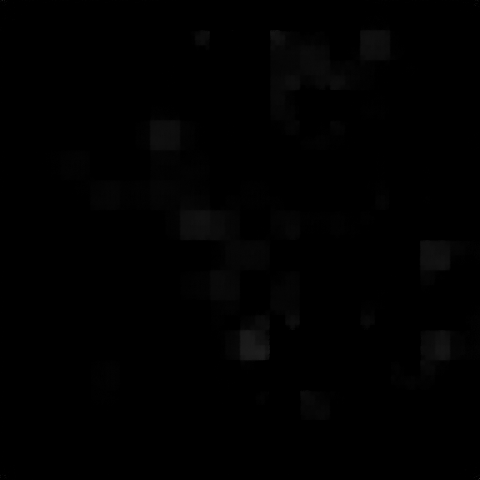
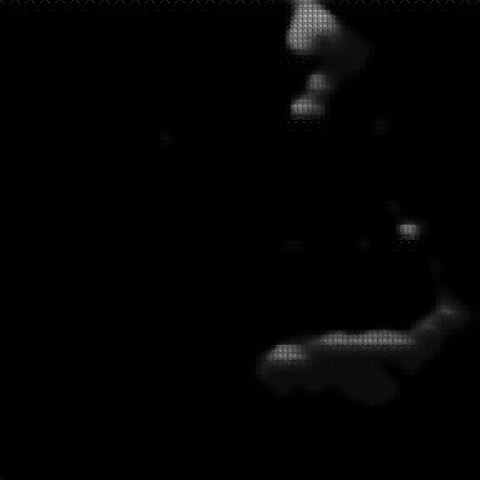
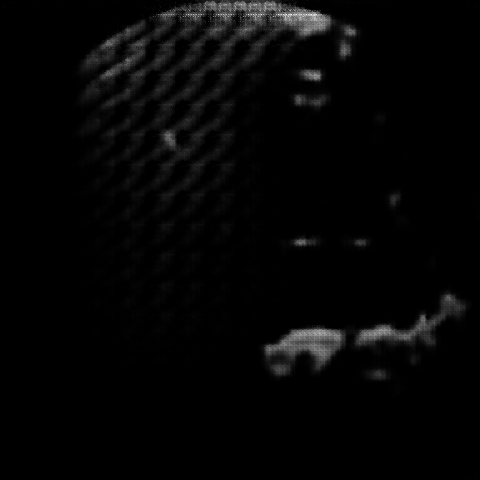
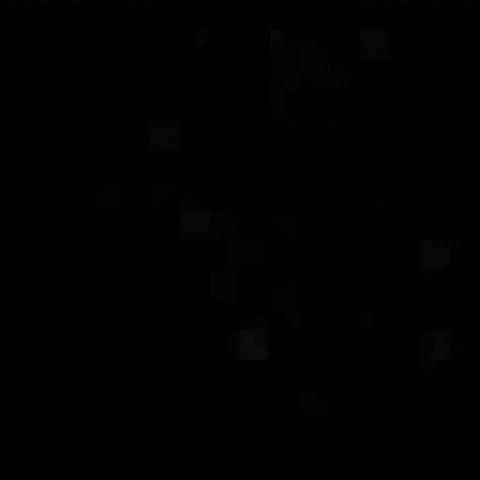
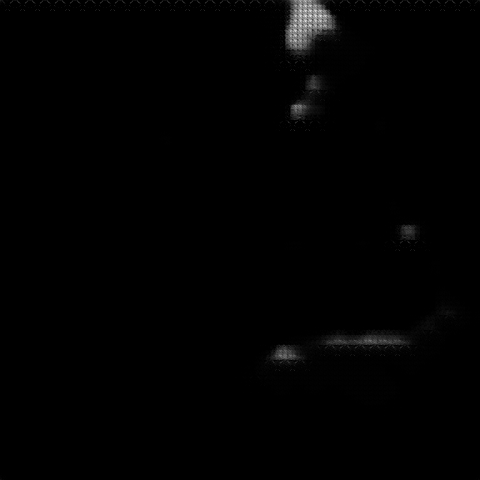
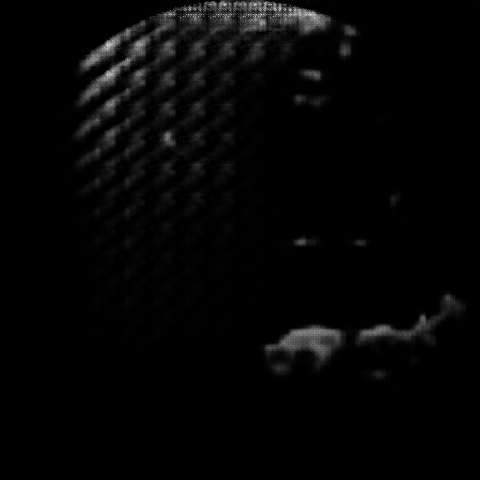
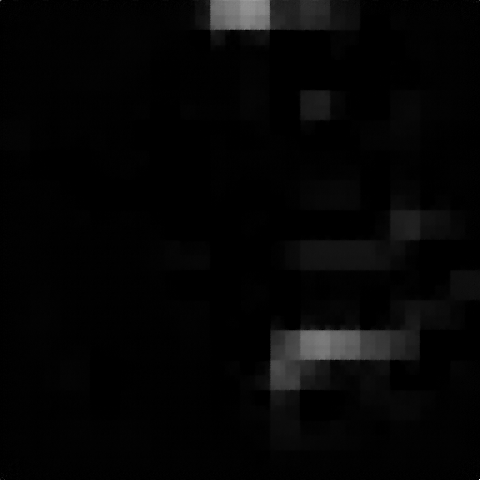
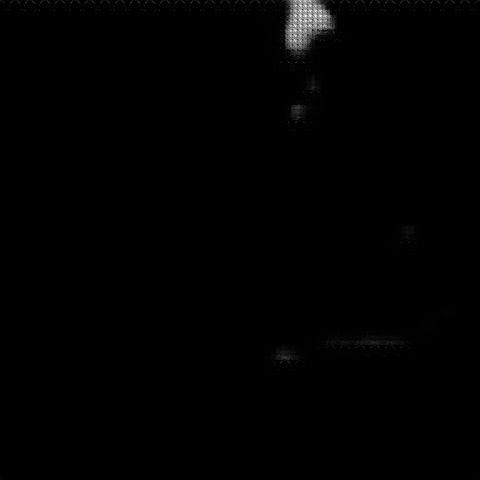
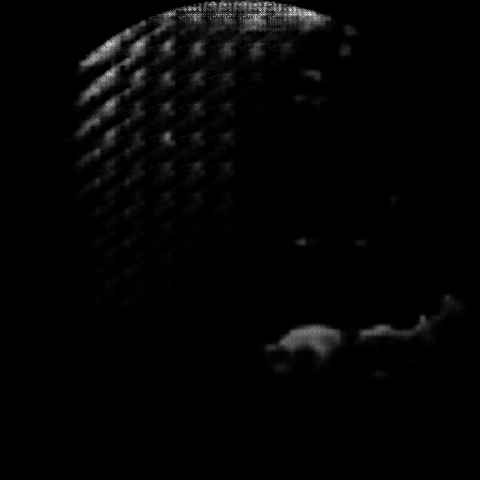
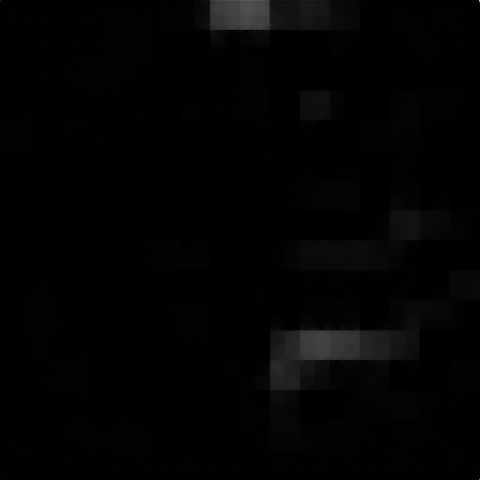
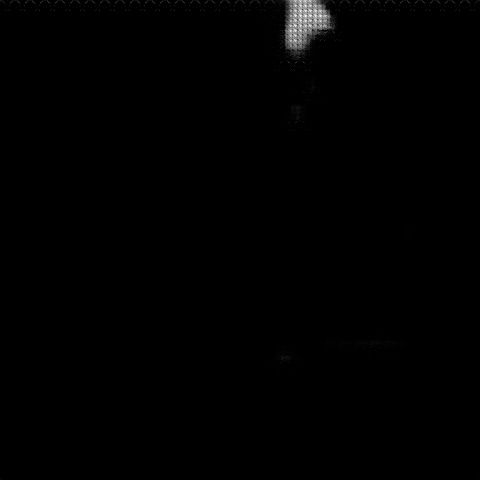
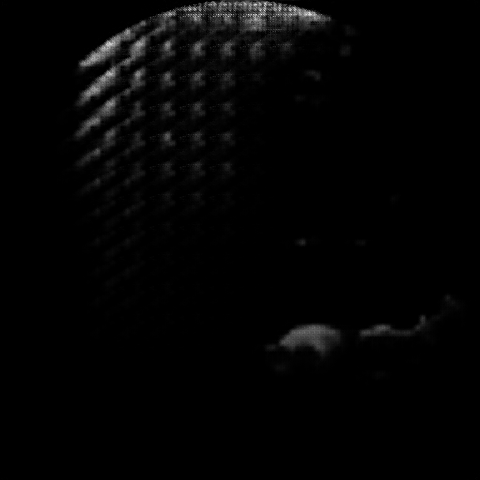
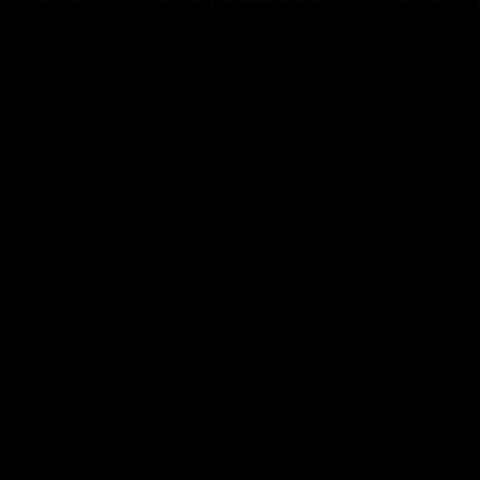
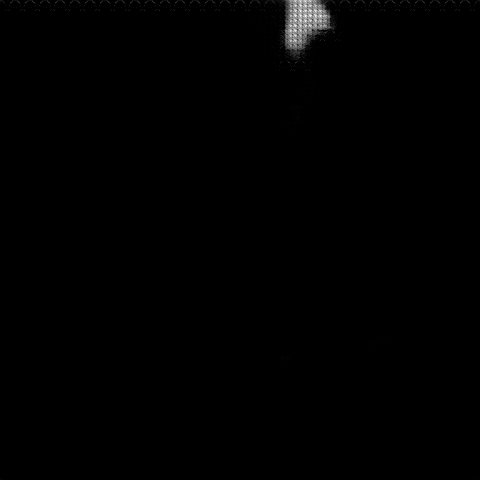
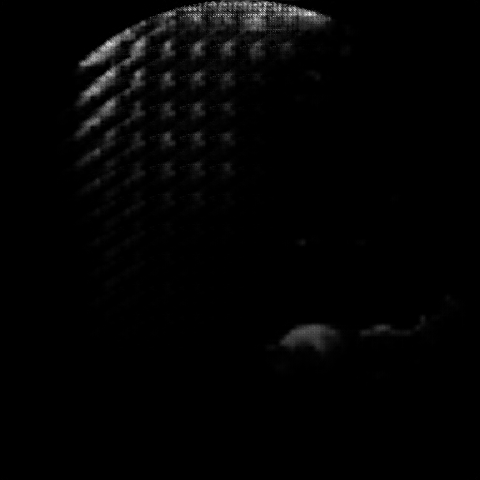
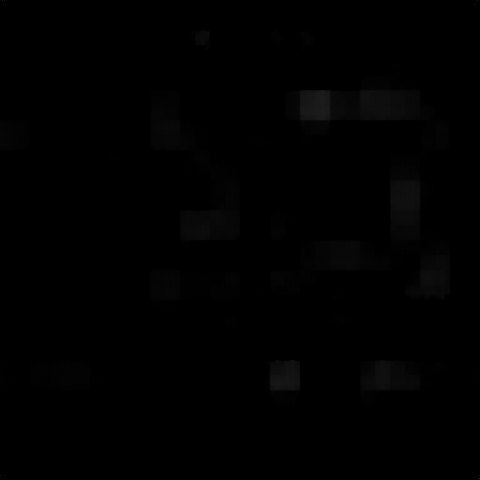
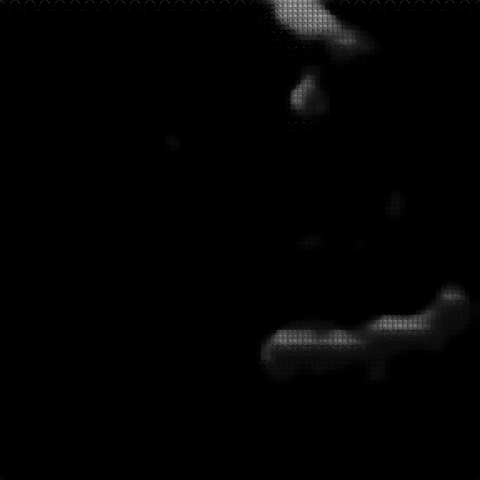
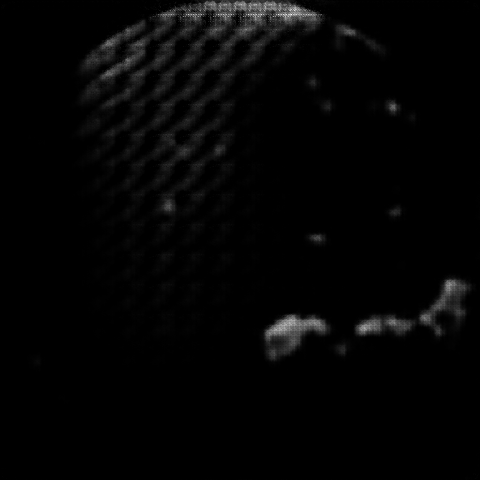
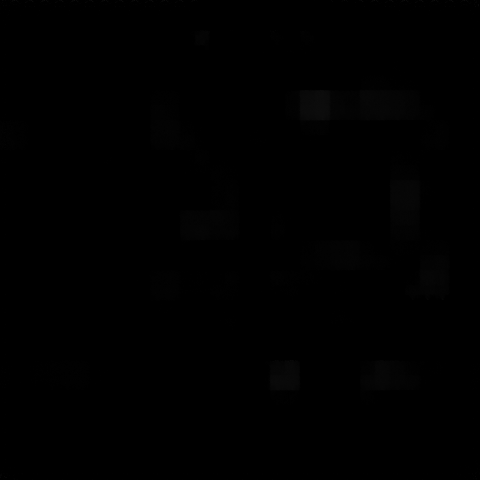
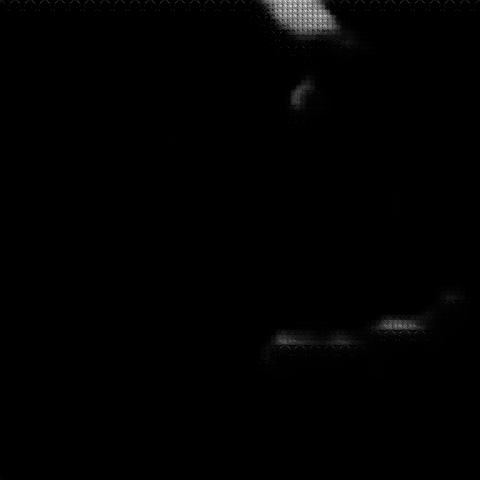
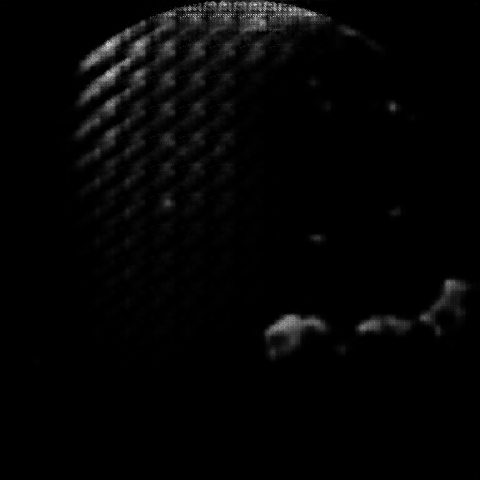
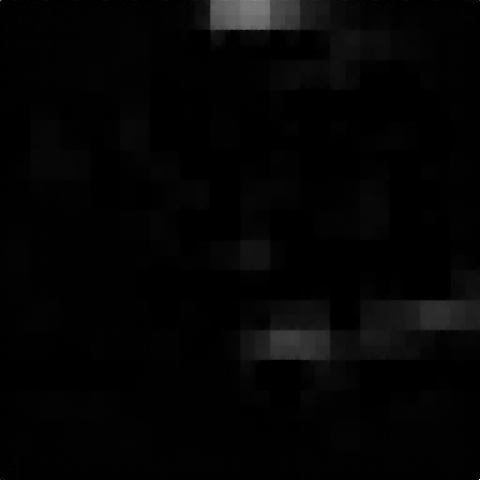
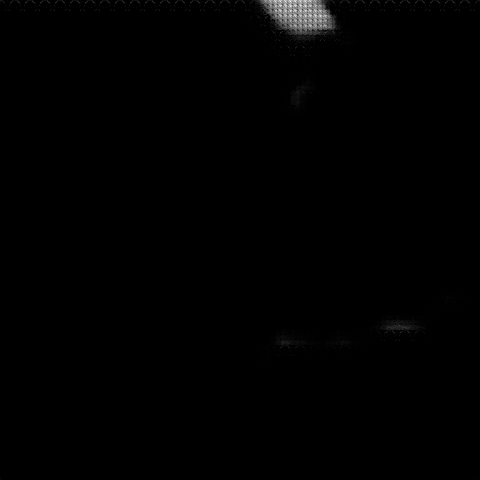
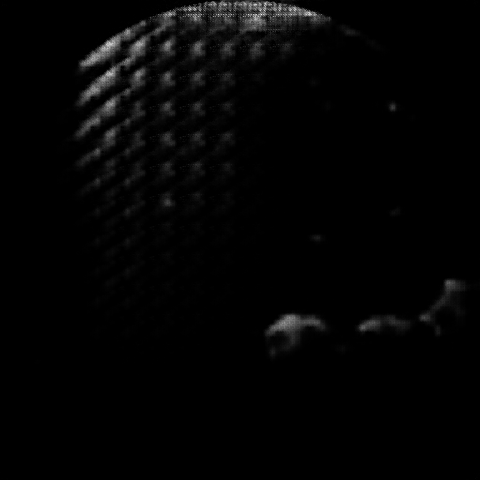
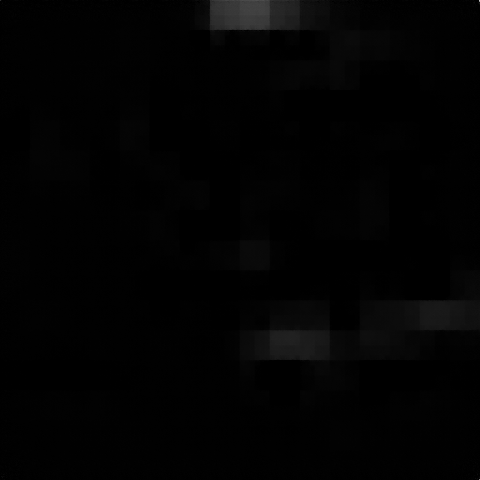
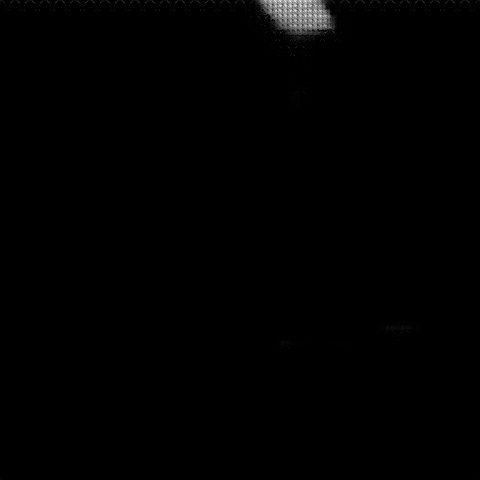
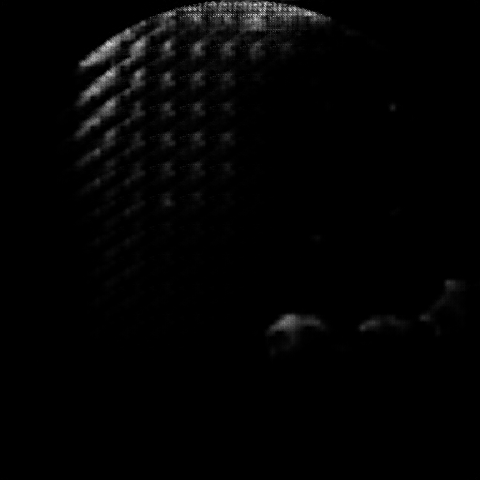
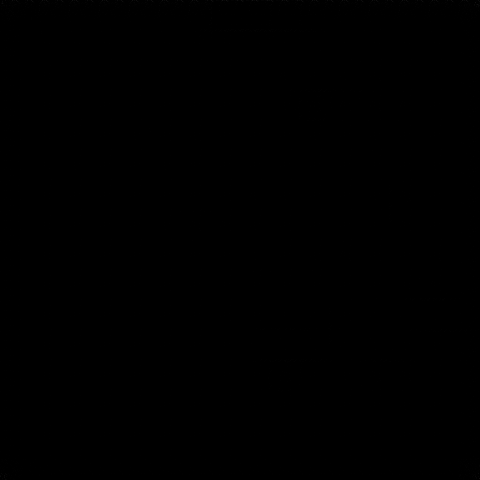
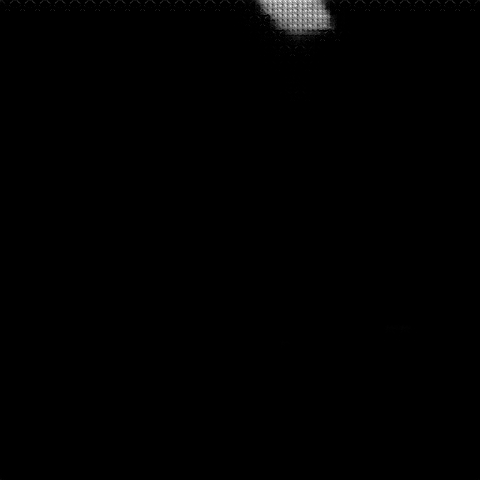
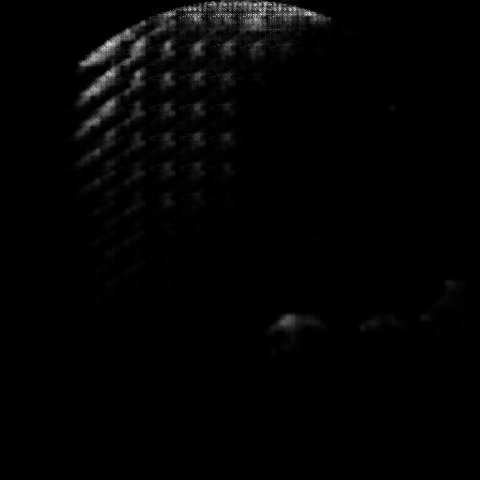
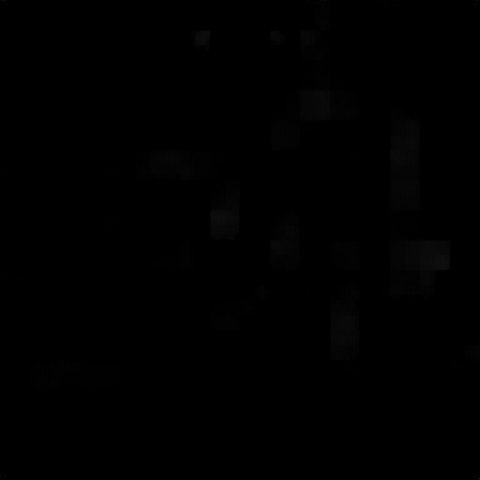
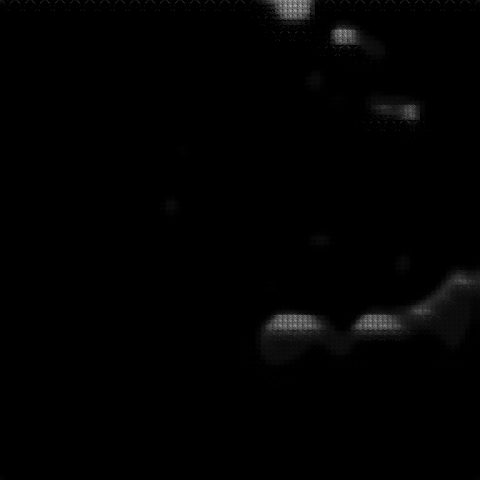
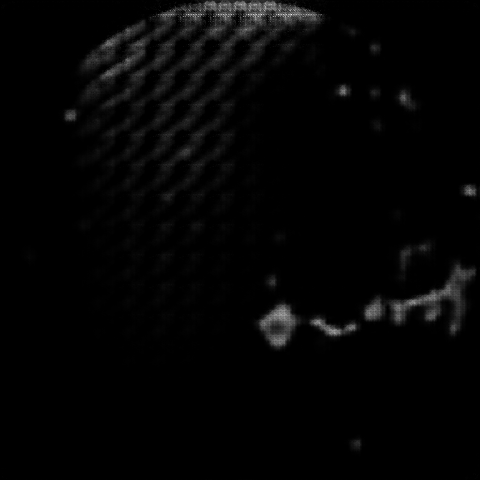
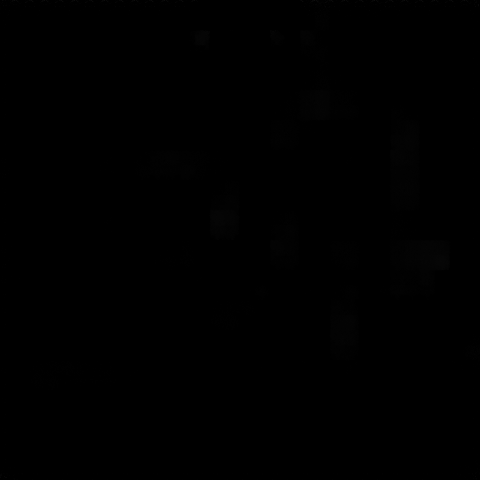
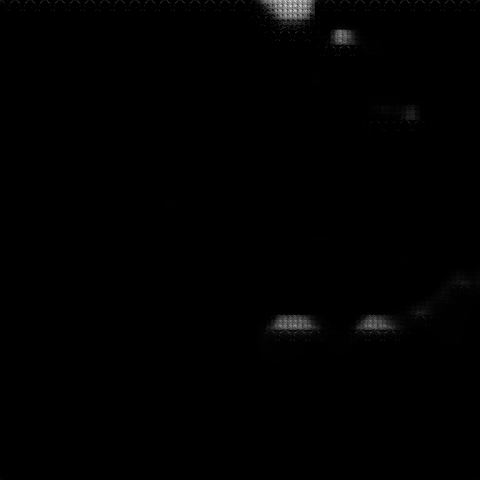
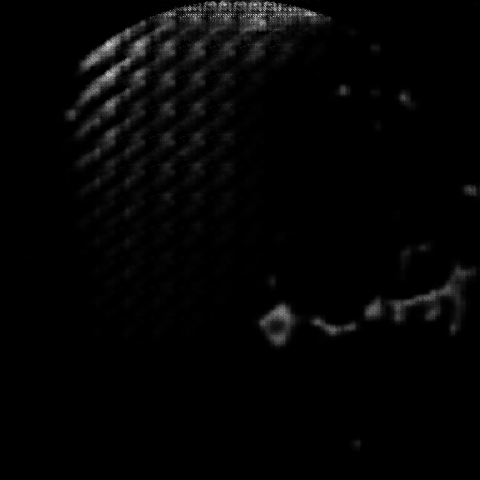
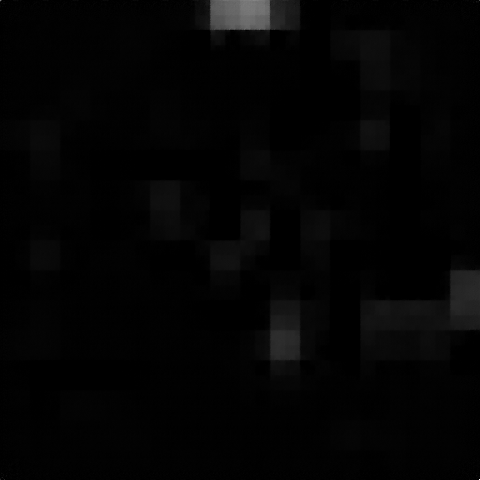
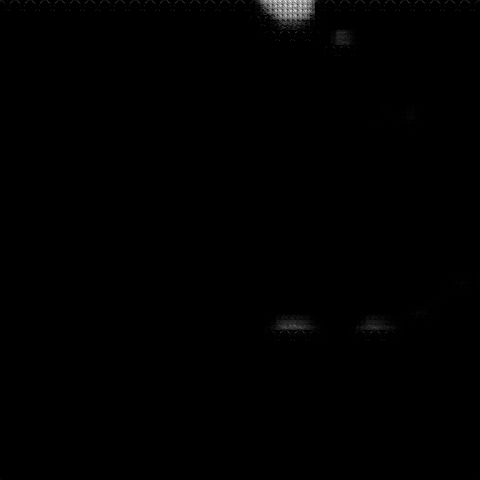
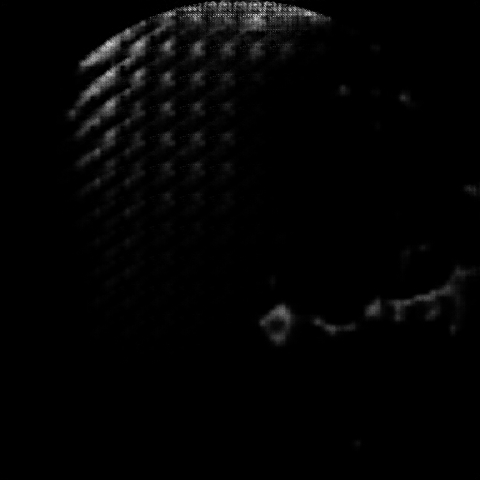
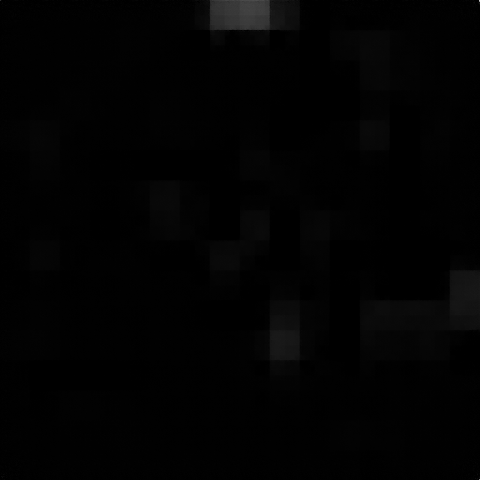
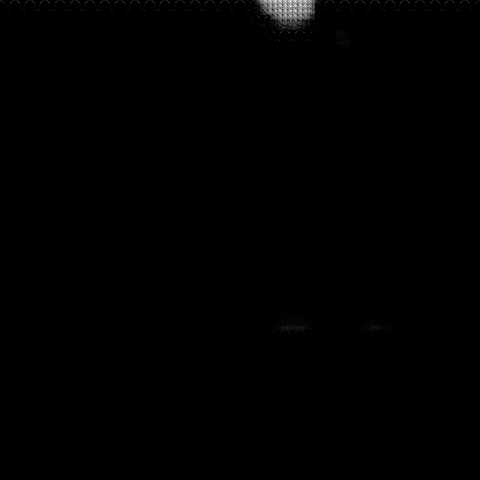
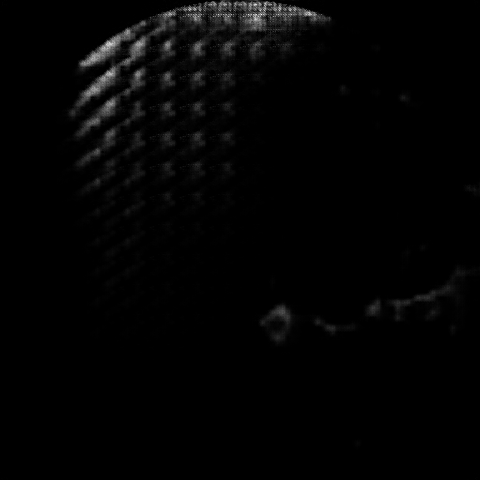
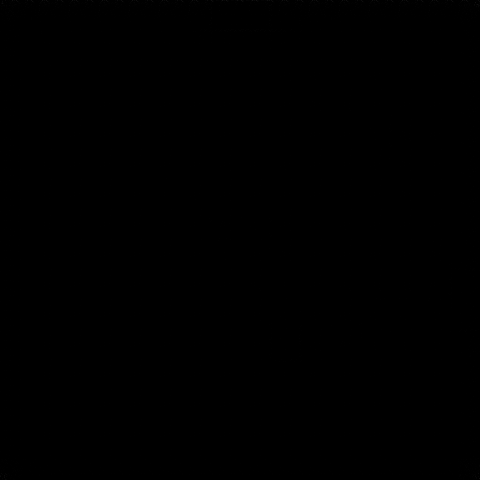
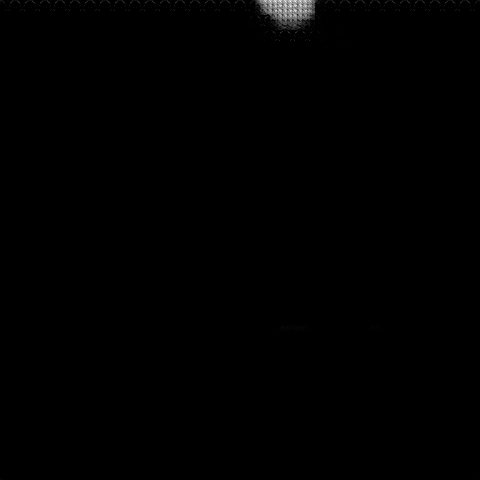
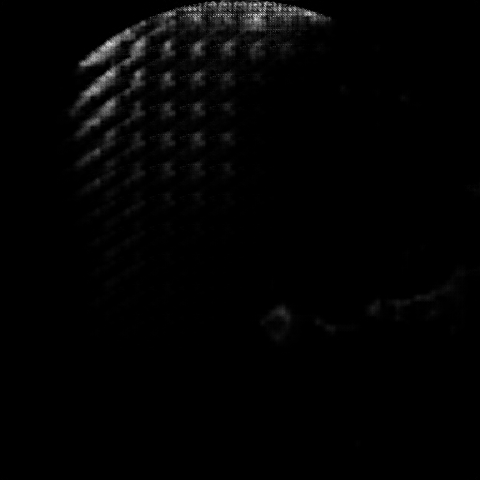
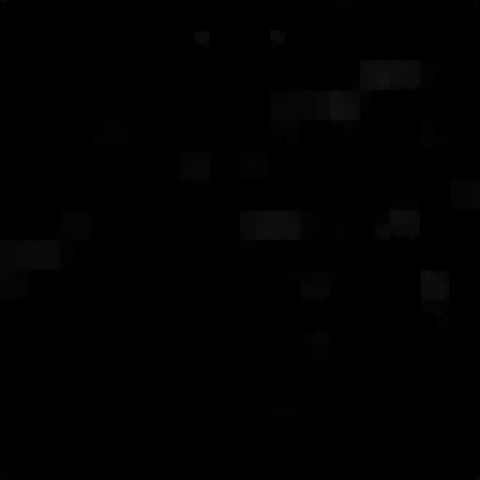
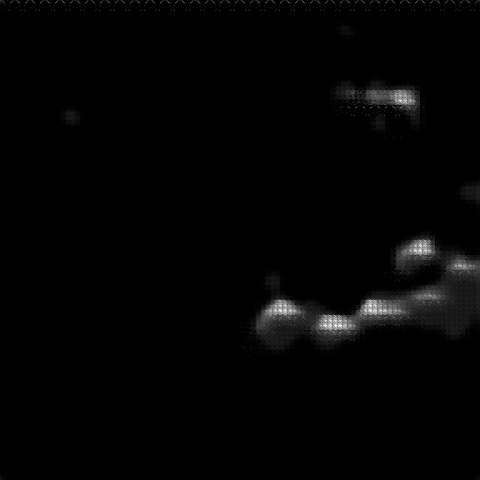
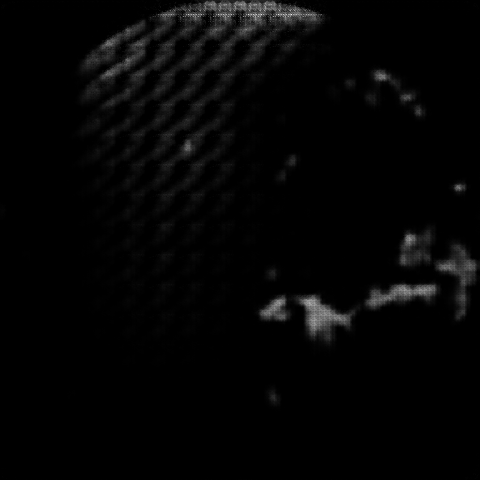
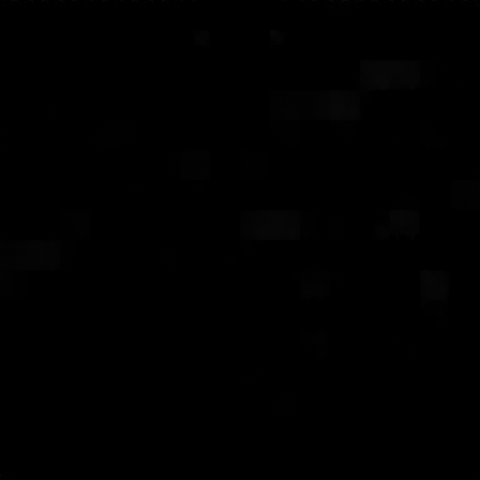
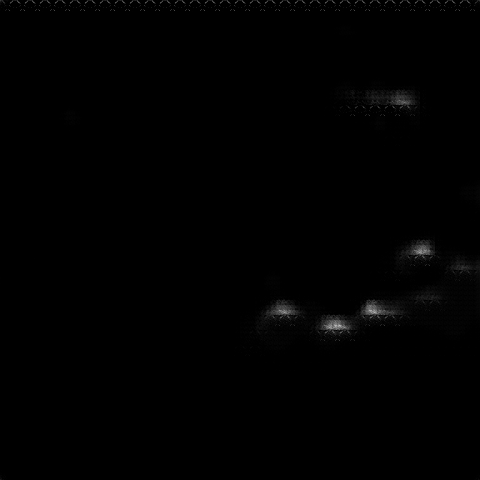
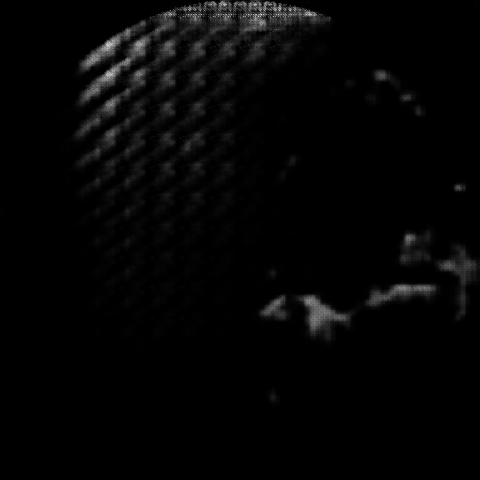
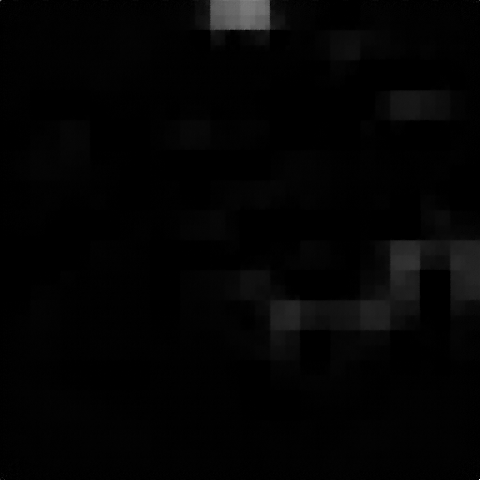
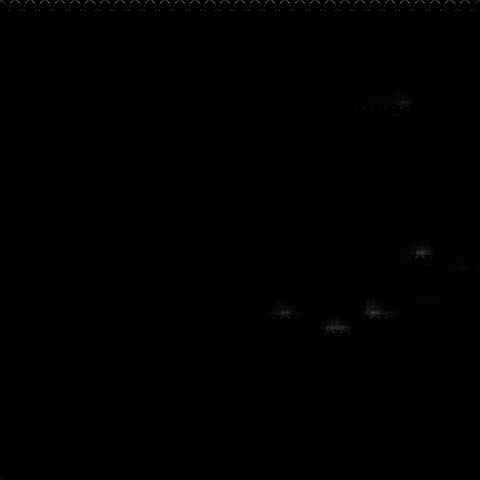
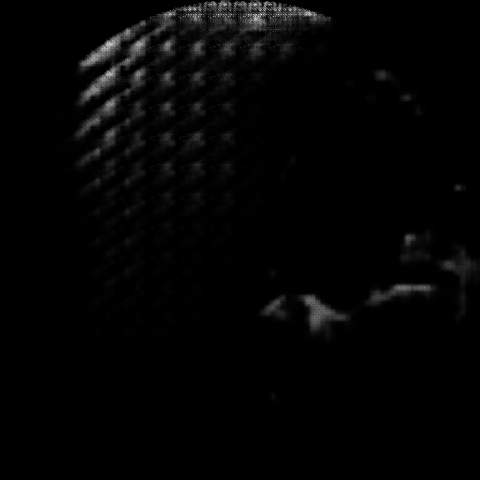
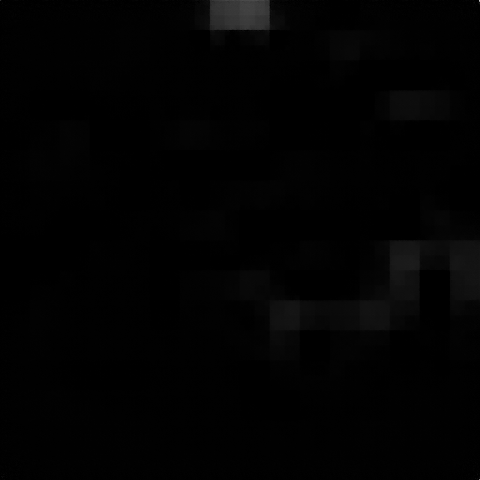
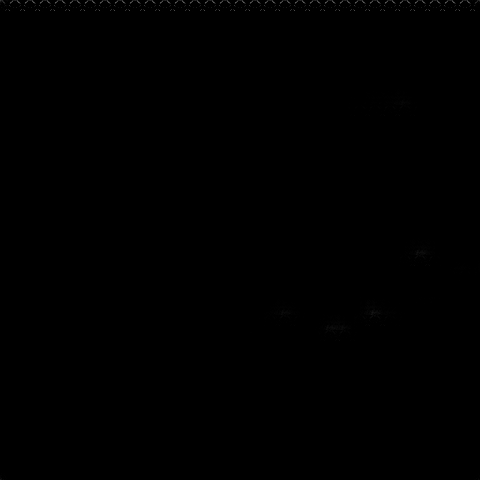
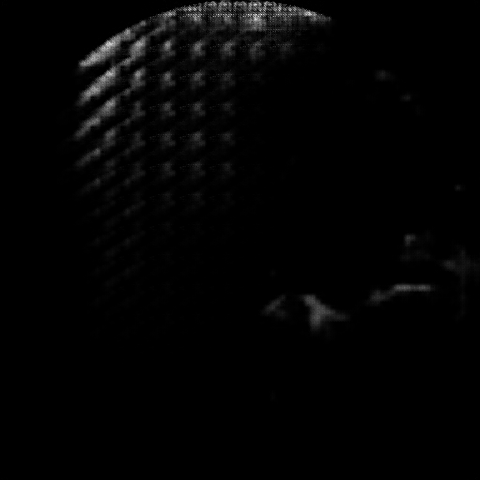
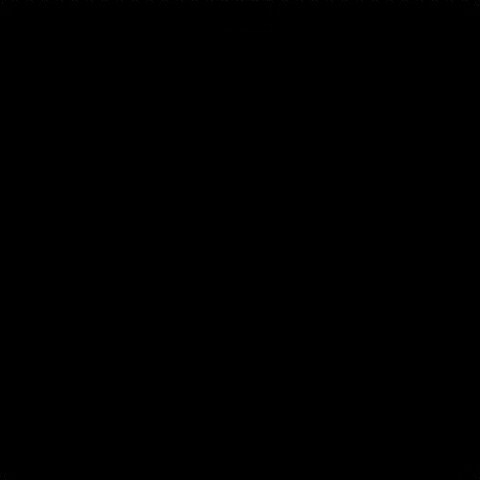
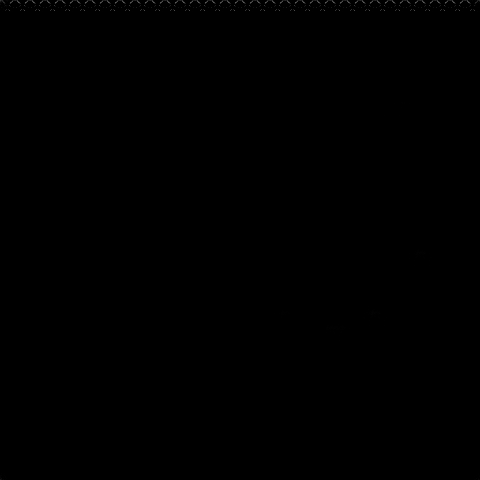
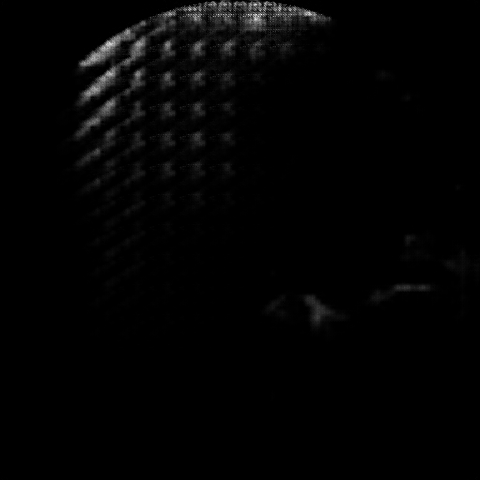
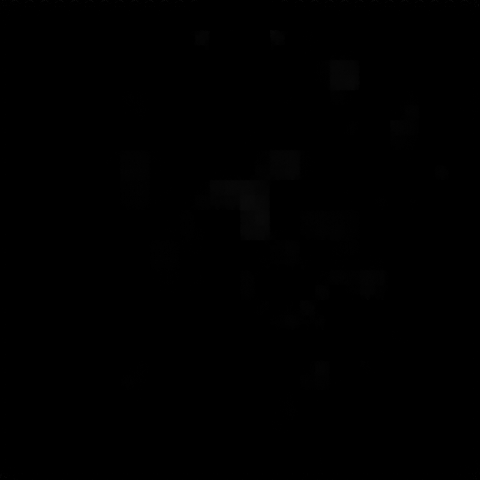
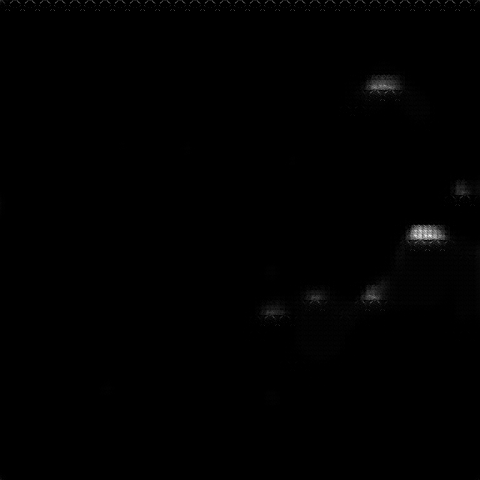
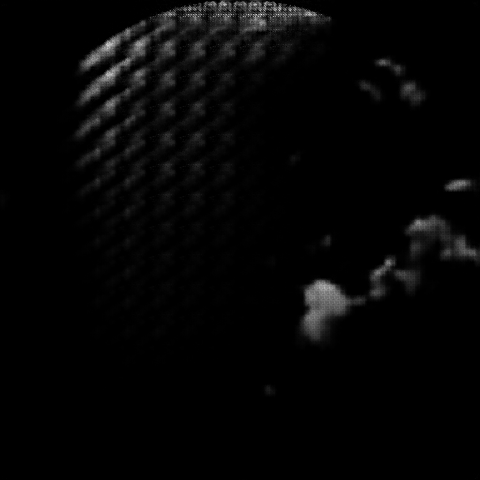
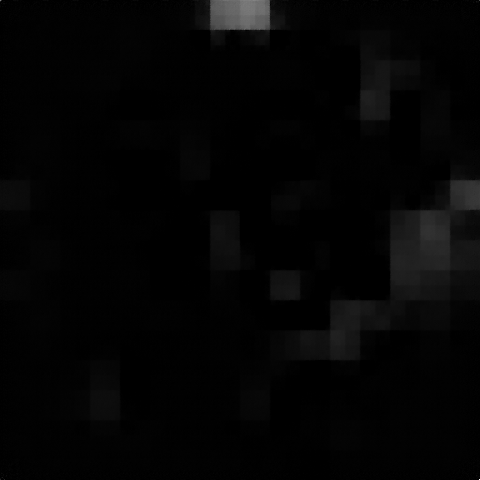
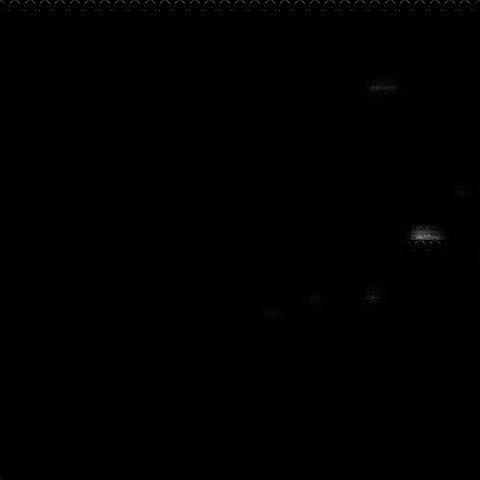
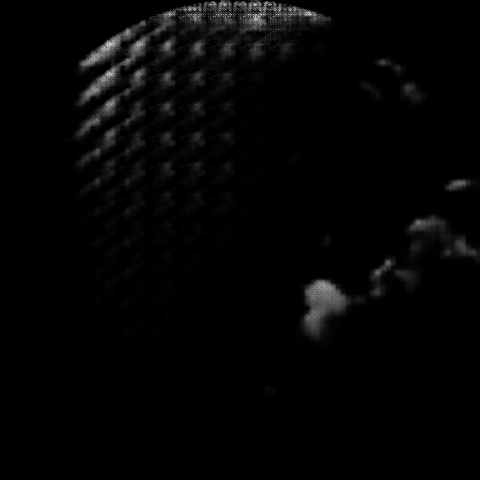
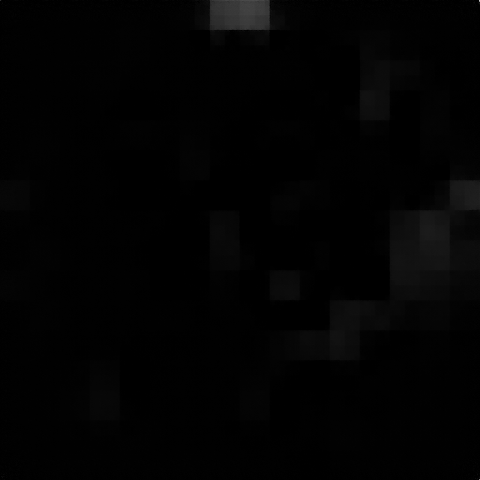
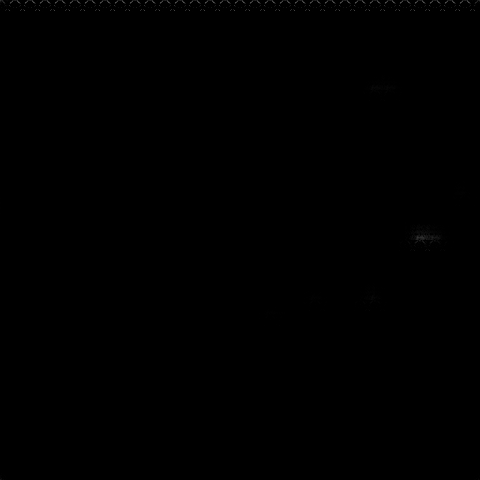
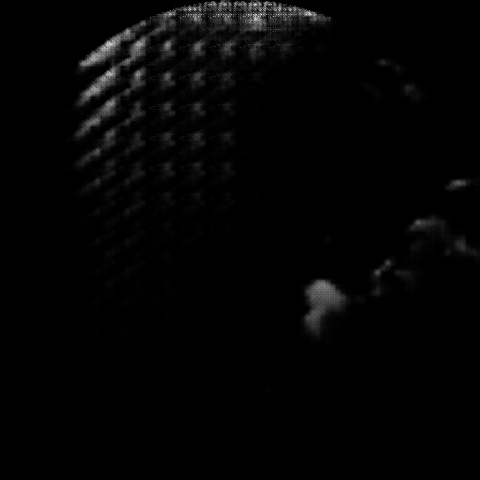
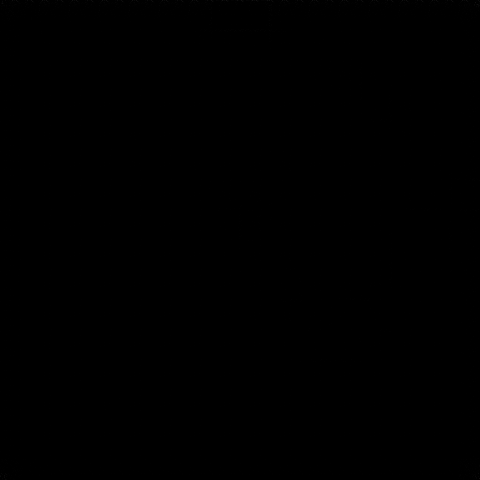
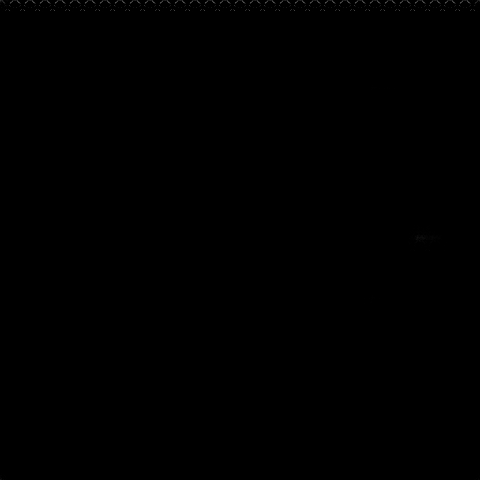
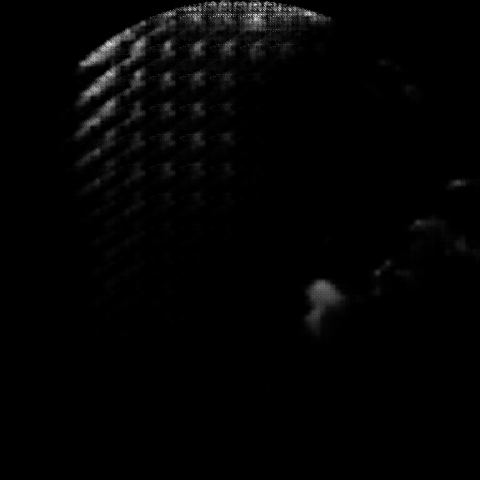
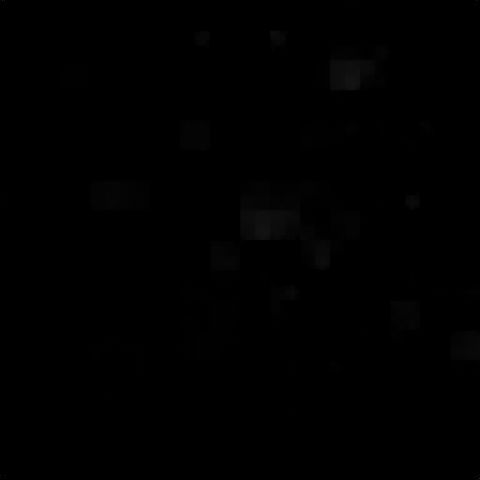
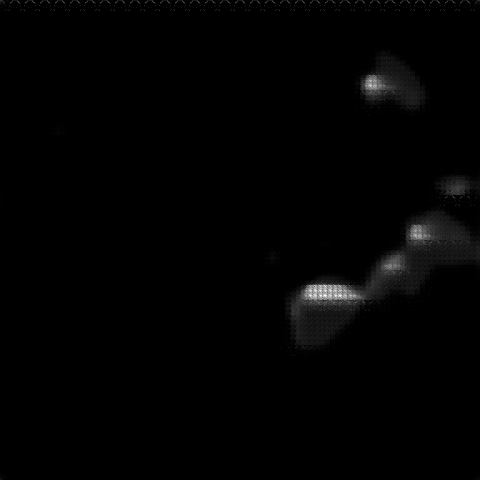
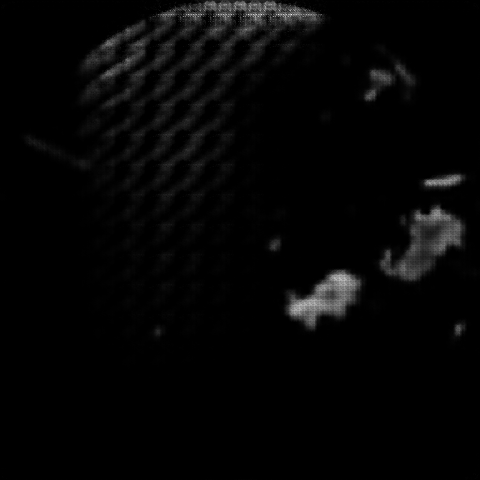
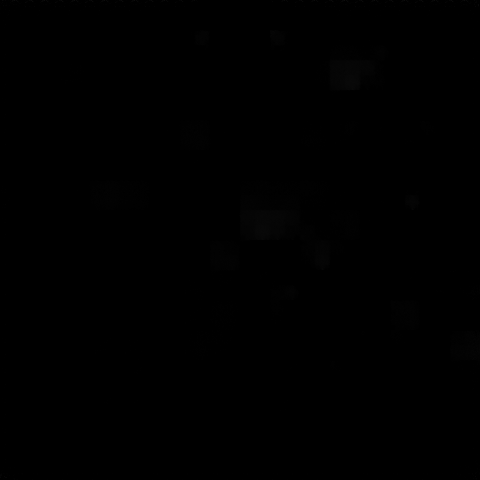
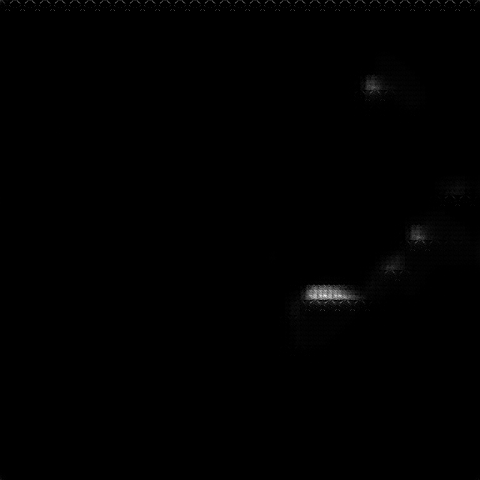
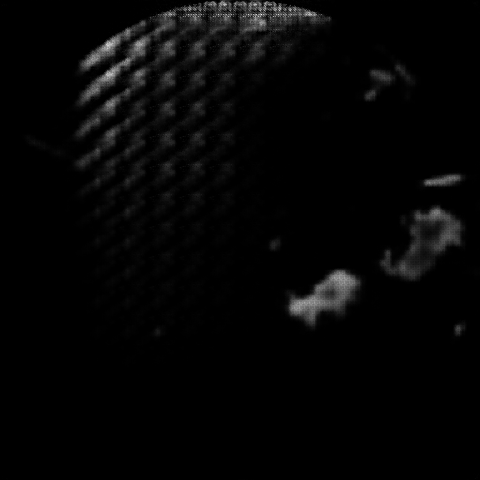
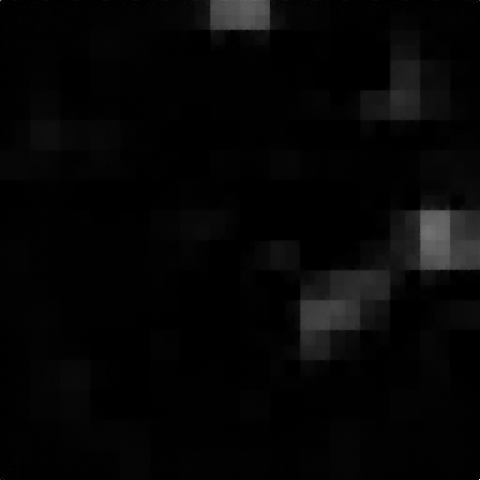
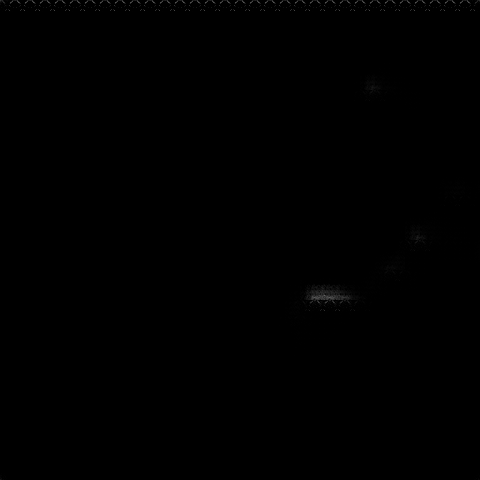
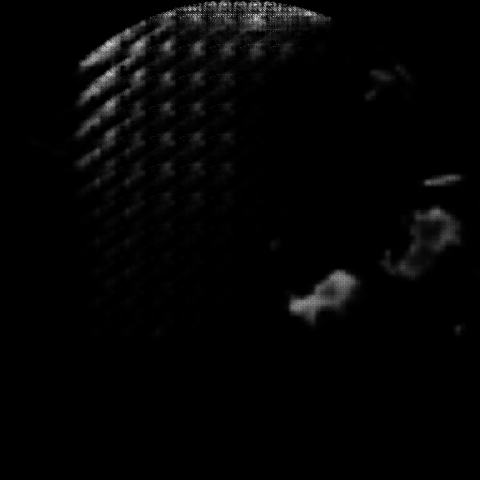
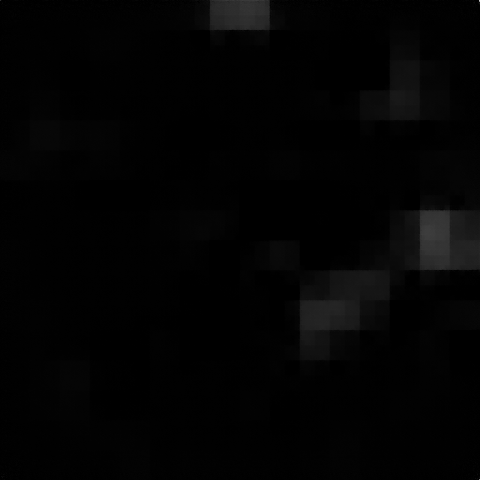
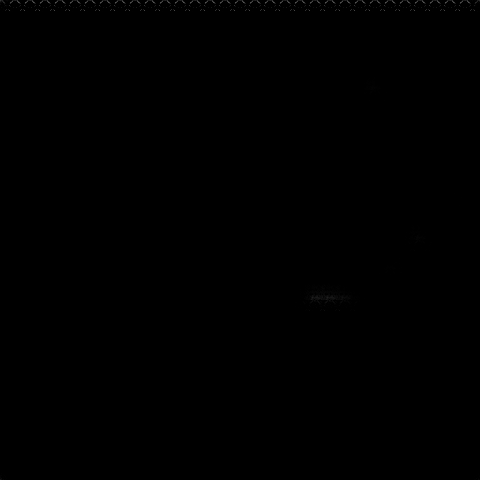
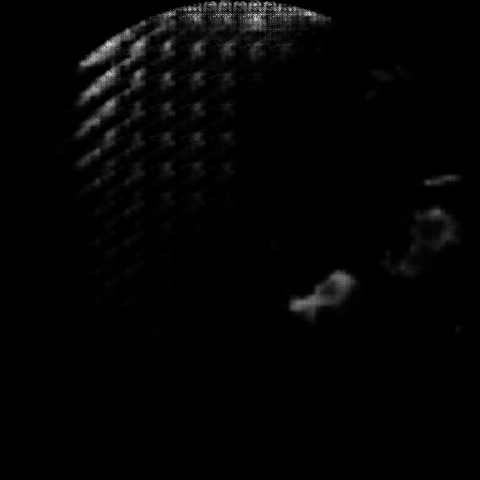
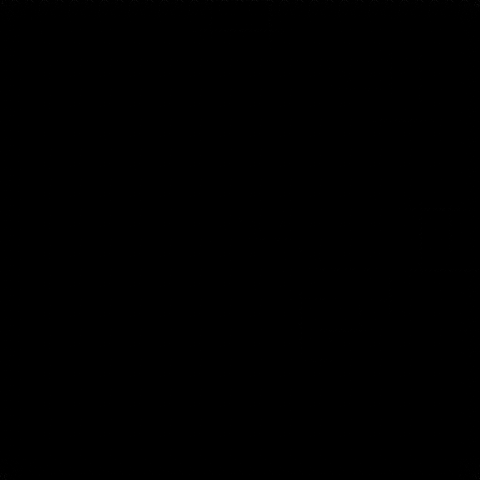
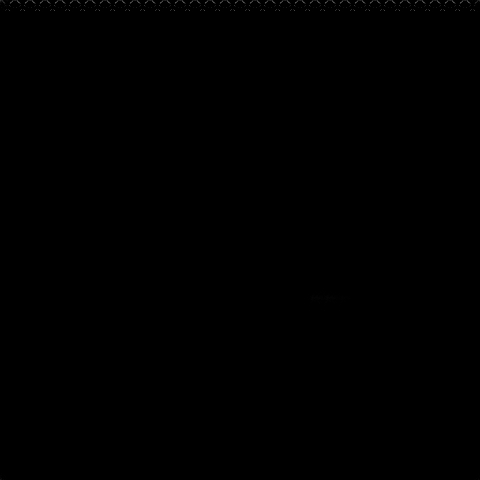
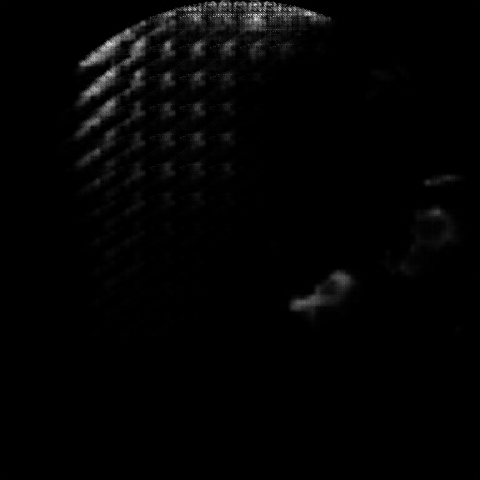
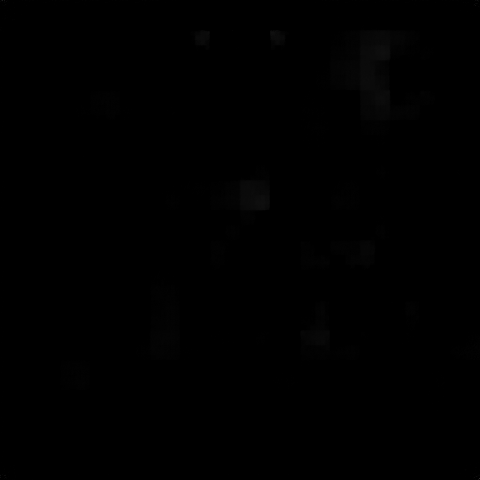
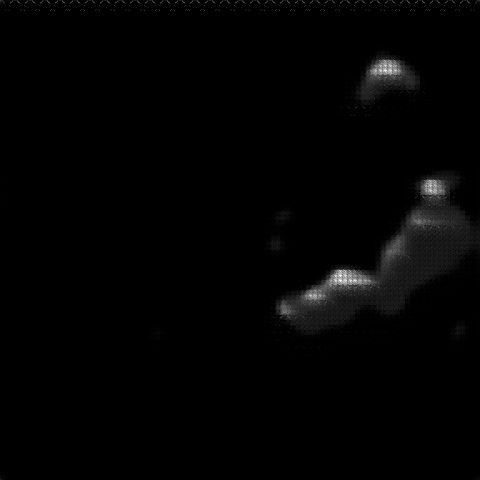
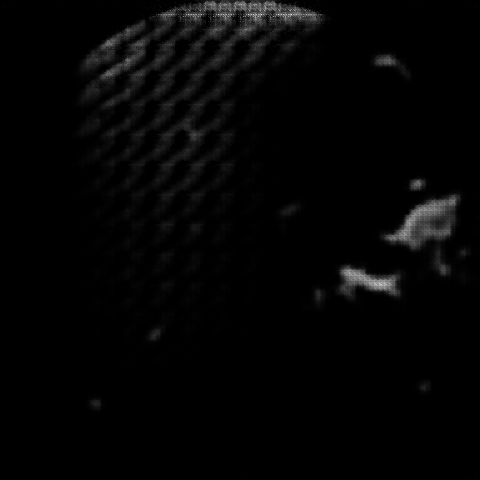
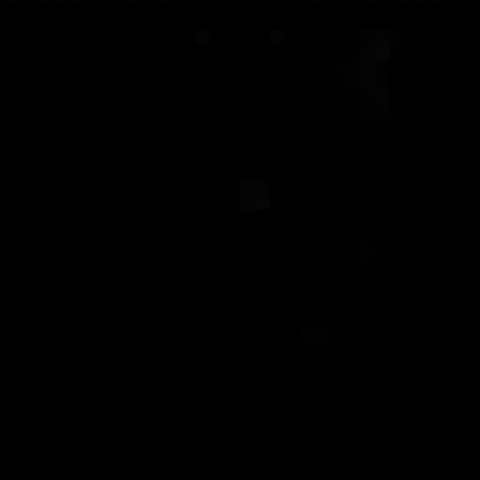
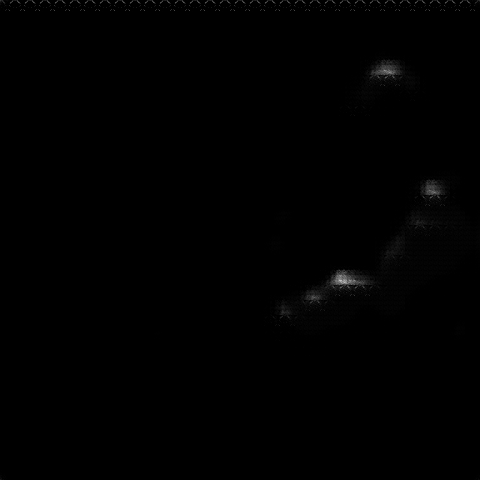
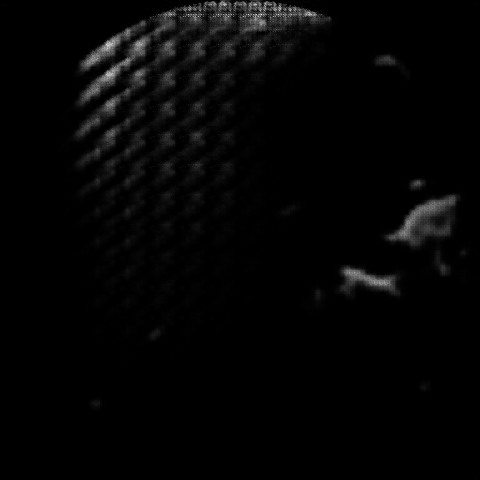
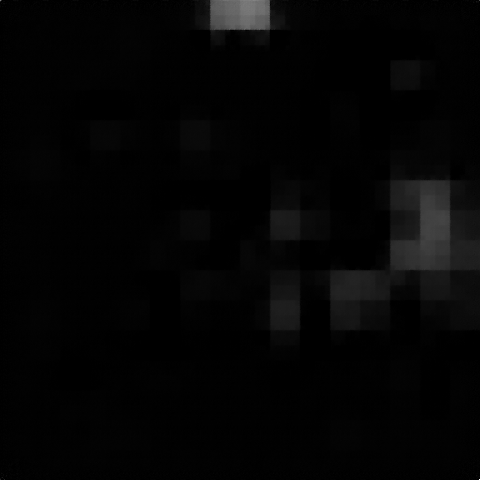
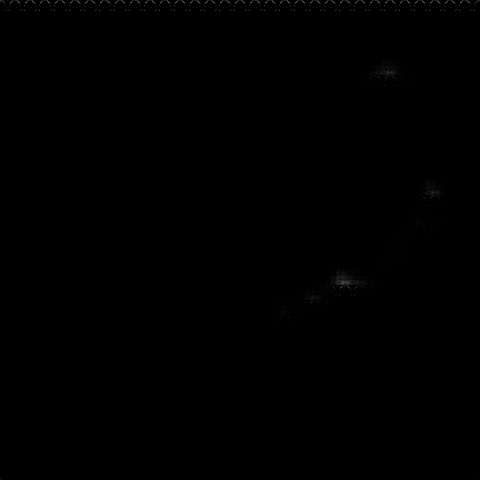
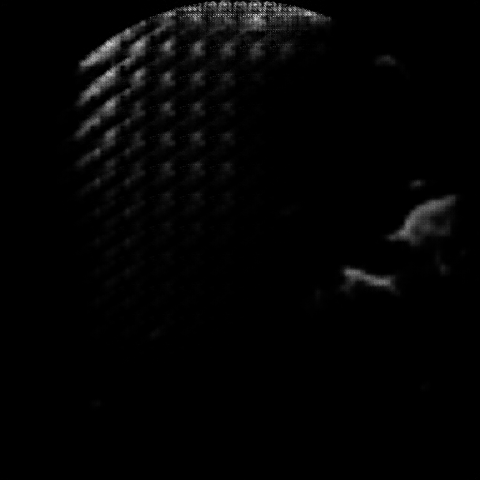
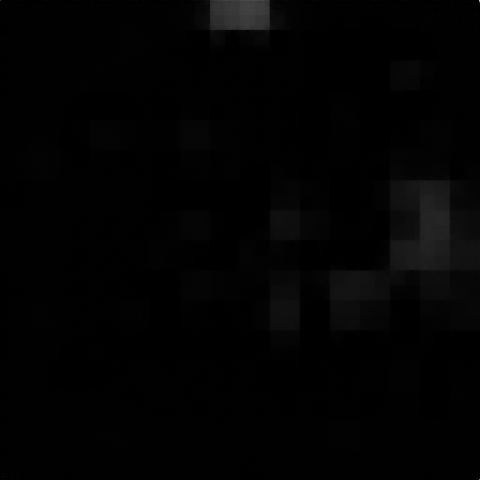
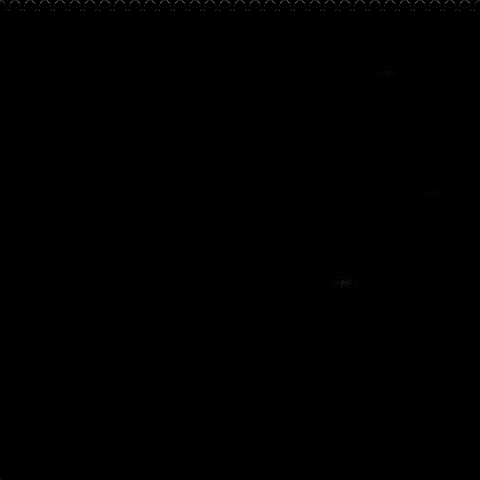
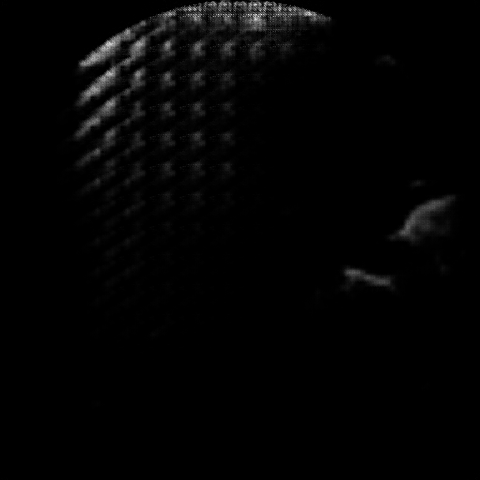
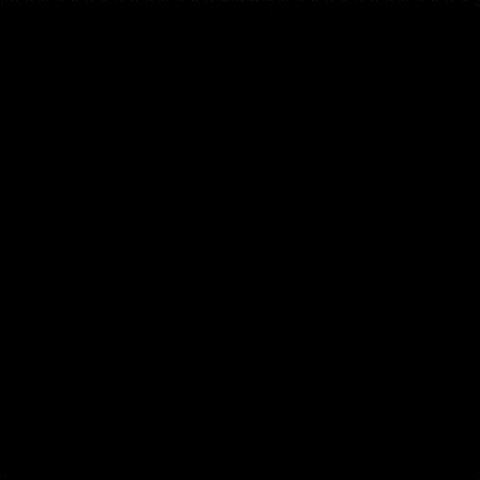
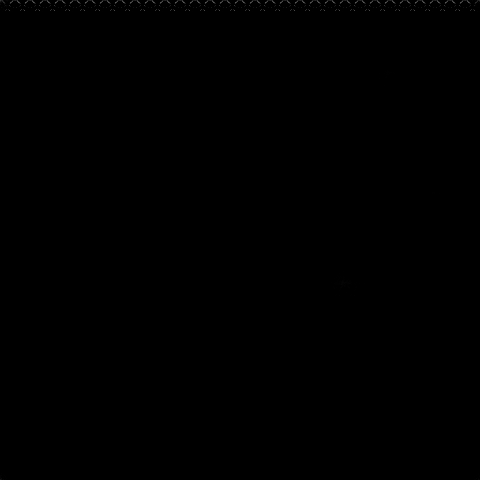
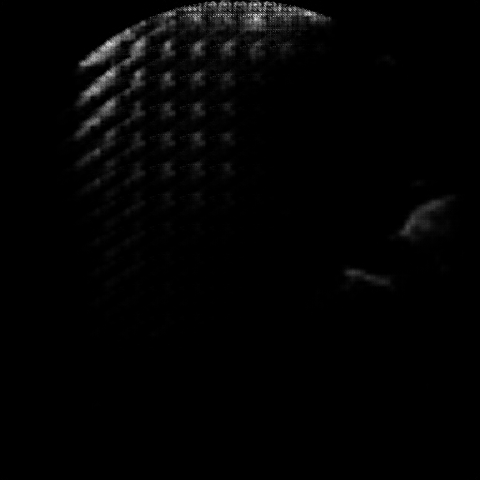
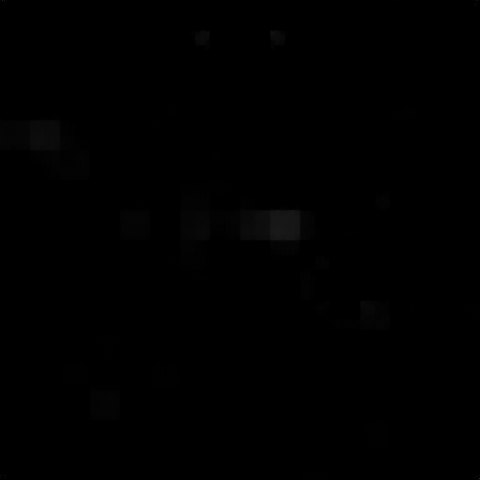
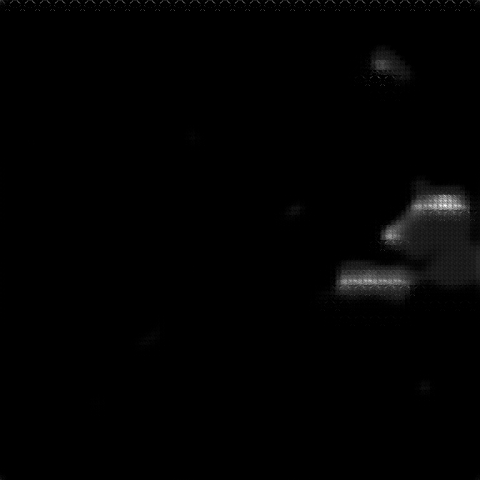
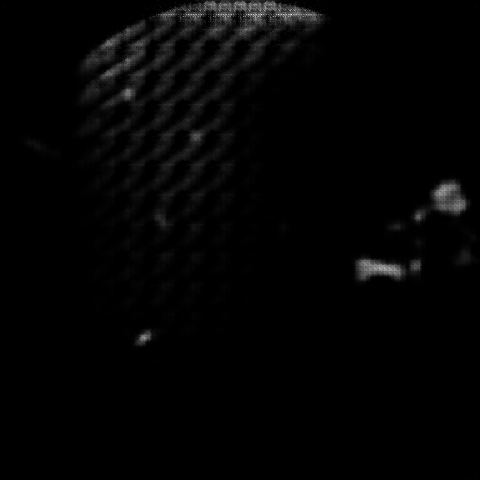
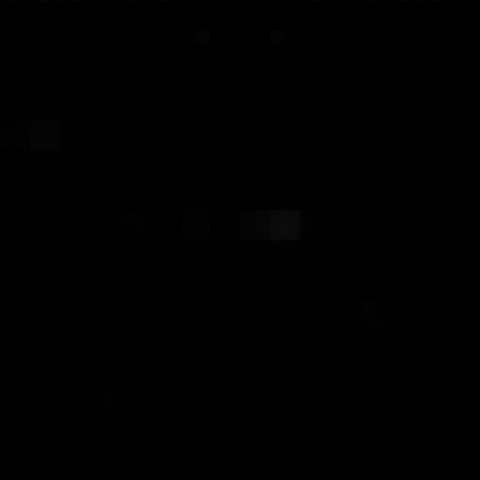
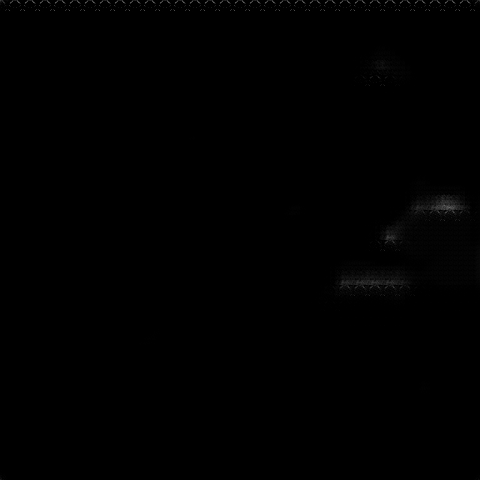
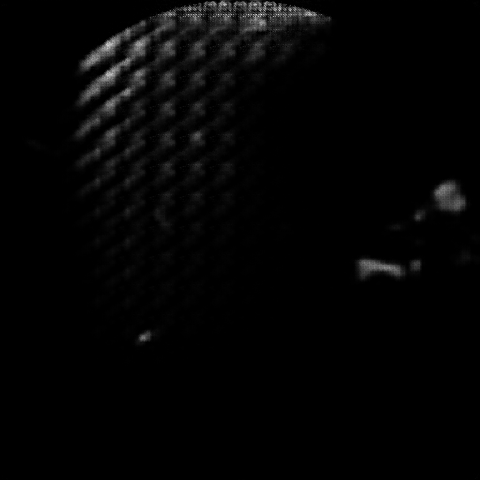
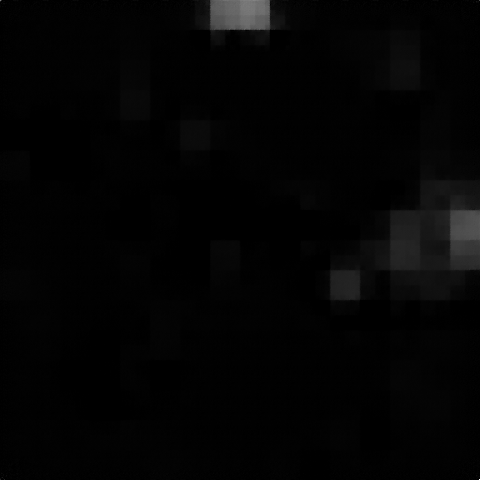
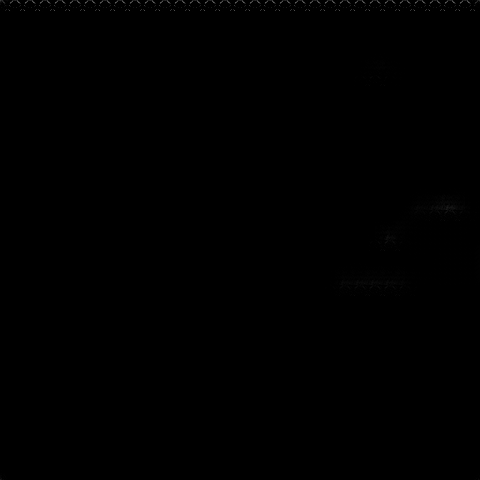
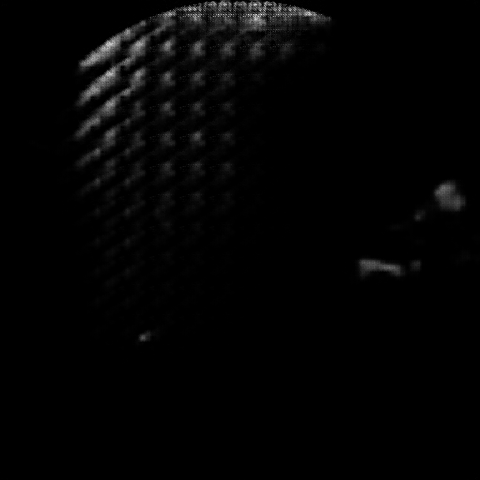
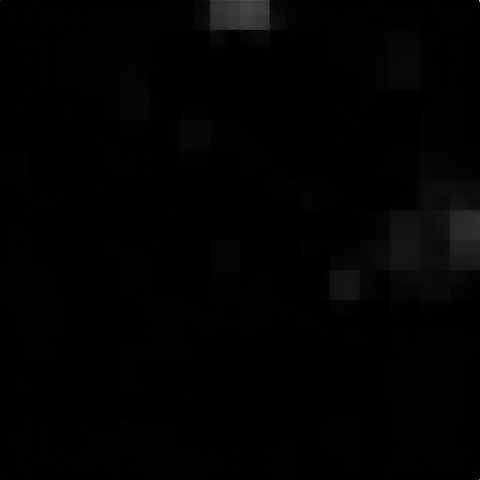
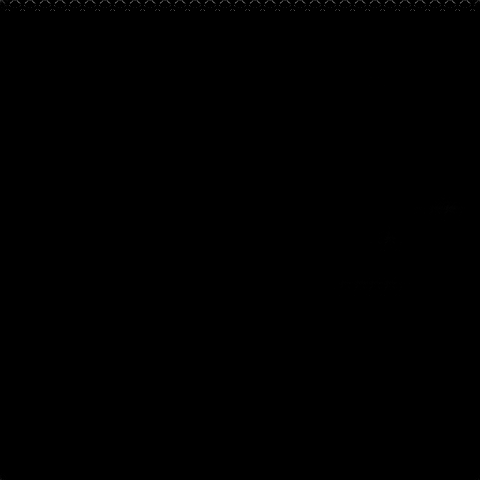
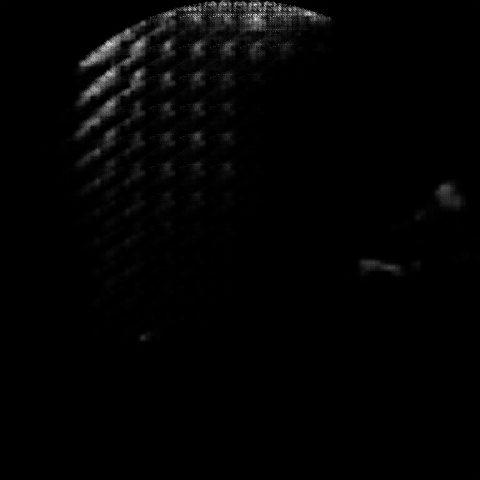
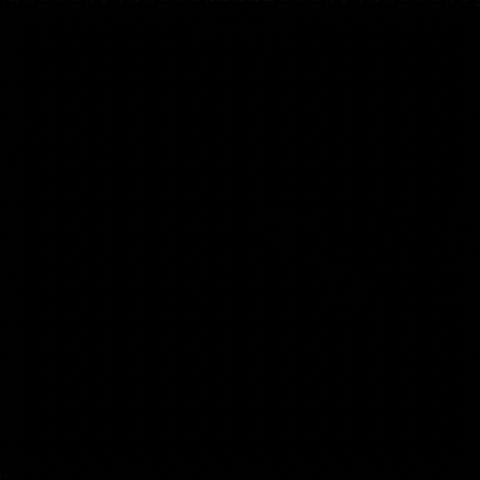
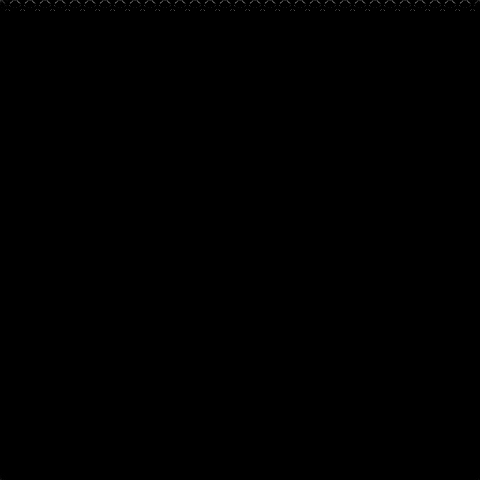
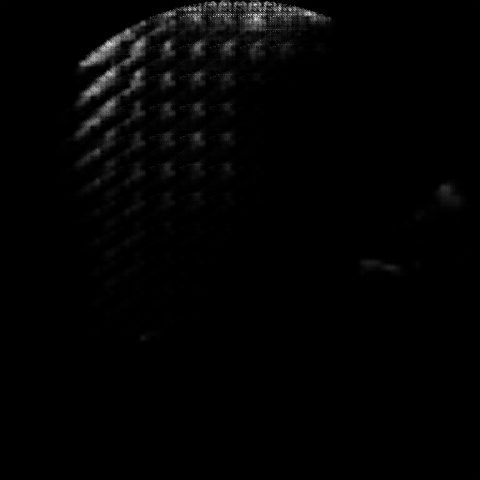
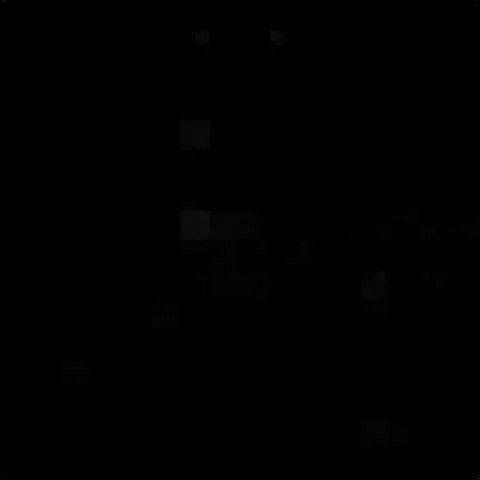
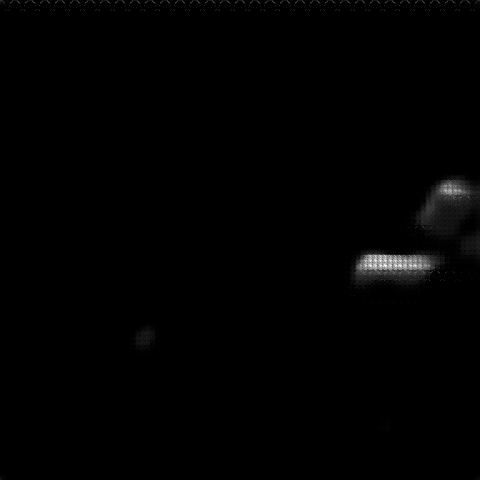
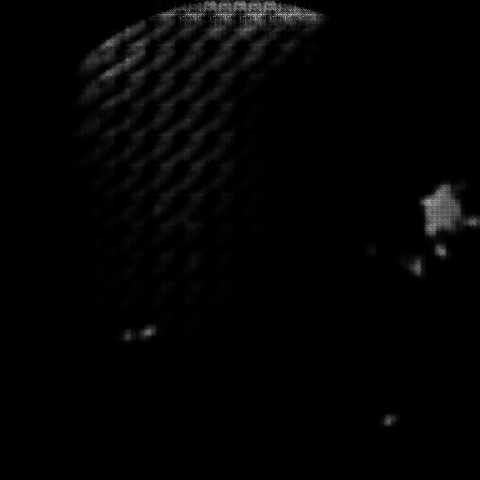

In [31]:
TITLES = ['conv2d_10000', 'convLSTM_BMSE_BMAE', 'trajGRU_BMSE_BMAE']
DATA = np.array([data, data2, data3])

fig = px.imshow(DATA, binary_string=True, facet_col=0, animation_frame=1)

for idx, annotation in enumerate(fig.layout.annotations):
    annotation.text = TITLES[idx]

fig.show()